In [1]:
import os, math
from enum import StrEnum, auto
from collections import defaultdict, namedtuple, Counter, deque
from dataclasses import dataclass
import typing
import itertools
import sqlite3
import pickle
import datetime
import multiprocessing as mp
import queue
import gc
import json
import decimal
from IPython.core.getipython import get_ipython

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from module.utils import *
from module.hdc import *
from module.constants import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng() 

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

with open(get_ipython().kernel.config['IPKernelApp']['connection_file'], 'r') as cf:
    notebook_fname = json.load(cf)['jupyter_session']
    notebook_fname = os.path.basename(notebook_fname)

print(notebook_fname)

xp = cupy
transf_learn22.ipynb


In [3]:
%run sequencing_sp2.ipynb # req-d for sequences depickling

# Data Loading

In [4]:
%time
train_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.train_db_file_name))
test_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_db_file_name))

test_results_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_results_db_file_name, with_prefix=False), autocommit=True)
test_results_db_con.execute('CREATE TABLE IF NOT EXISTS test_runs(test_run_id INTEGER PRIMARY KEY, dummy)')

transfs_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.transfs_db_file_name, with_prefix=False), autocommit=True)
transfs_db_con.execute('CREATE TABLE IF NOT EXISTS features(encoding, type, x, y, radius, angle, bitmap_mask_nzb, nzb)')
transfs_db_con.execute('CREATE TABLE IF NOT EXISTS points(encoding, count, non_zero_bits, output_bit, nzb_list)')
transfs_db_con.execute('CREATE TABLE IF NOT EXISTS clusters(encoding, transf_code, output_bit, metas, nzb_list)');

CPU times: user 9 μs, sys: 1e+03 ns, total: 10 μs
Wall time: 20.3 μs


In [5]:
# df_points = pd.read_sql('SELECT ROWID, points FROM points', con=transfs_db_con)

# for points_row in tqdm(df_points.itertuples(), total=len(df_points)):
#     row_id = int(points_row.rowid)
#     points = pickle.loads(points_row.points)
#     nzb_list = list(map(lambda p: np.flatnonzero(p), points))
#     transfs_db_con.execute('UPDATE points SET nzb_list=:nzb_list WHERE ROWID=:rowid', {'nzb_list': pickle.dumps(nzb_list), 'rowid': row_id})

In [6]:
# df_points = pd.read_sql('SELECT ROWID, nzb_list FROM points', con=transfs_db_con)

# for points_row in tqdm(df_points.itertuples(), total=len(df_points)):
#     row_id = int(points_row.rowid)
#     nzb_list = pickle.loads(points_row.nzb_list)
#     nzb_list = list(map(lambda nzb: list(map(int, nzb)), nzb_list))
#     transfs_db_con.execute('UPDATE points SET nzb_list=:nzb_list WHERE ROWID=:rowid', {'nzb_list': pickle.dumps(nzb_list), 'rowid': row_id})

In [7]:
# df_features = pd.read_sql('SELECT ROWID, sbv FROM features', con=transfs_db_con)

# for feature_row in tqdm(df_features.itertuples(), total=len(df_features)):
#     row_id = int(feature_row.rowid)
#     feature = pickle.loads(feature_row.sbv)
#     nzb = np.flatnonzero(feature)
#     transfs_db_con.execute('UPDATE features SET nzb=:nzb WHERE ROWID=:rowid', {'nzb': pickle.dumps(nzb), 'rowid': row_id})

In [8]:
# df_features = pd.read_sql('SELECT ROWID, nzb FROM features', con=transfs_db_con)

# for feature_row in tqdm(df_features.itertuples(), total=len(df_features)):
#     row_id = int(feature_row.rowid)
#     nzb = pickle.loads(feature_row.nzb)
#     nzb = list(map(int, nzb))
#     transfs_db_con.execute('UPDATE features SET nzb=:nzb WHERE ROWID=:rowid', {'nzb': pickle.dumps(nzb), 'rowid': row_id})

In [9]:
# df_features = pd.read_sql('SELECT ROWID, bitmap_mask_nzb FROM features', con=transfs_db_con)

# for feature_row in tqdm(df_features.itertuples(), total=len(df_features)):
#     row_id = int(feature_row.rowid)
#     bitmap_mask_nzb = pickle.loads(feature_row.bitmap_mask_nzb)
#     bitmap_mask_nzb = list(map(int, bitmap_mask_nzb))
#     transfs_db_con.execute('UPDATE features SET bitmap_mask_nzb=:bitmap_mask_nzb WHERE ROWID=:rowid', {'bitmap_mask_nzb': pickle.dumps(bitmap_mask_nzb), 'rowid': row_id})

In [10]:
# df_clusters = pd.read_sql('SELECT ROWID, sbv FROM clusters', con=transfs_db_con)

# for clusters_row in tqdm(df_clusters.itertuples(), total=len(df_clusters)):
#     row_id = int(clusters_row.rowid)
#     clusters = pickle.loads(clusters_row.sbv)
#     nzb_list = list(map(lambda c: np.flatnonzero(c), clusters))
#     transfs_db_con.execute('UPDATE clusters SET nzb_list=:nzb_list WHERE ROWID=:rowid', {'nzb_list': pickle.dumps(nzb_list), 'rowid': row_id})

In [11]:
# df_clusters = pd.read_sql('SELECT ROWID, nzb_list FROM clusters', con=transfs_db_con)

# for clusters_row in tqdm(df_clusters.itertuples(), total=len(df_clusters)):
#     row_id = int(clusters_row.rowid)
#     nzb_list = pickle.loads(clusters_row.nzb_list)
#     nzb_list = list(map(lambda nzb: list(map(int, nzb)), nzb_list))
#     transfs_db_con.execute('UPDATE clusters SET nzb_list=:nzb_list WHERE ROWID=:rowid', {'nzb_list': pickle.dumps(nzb_list), 'rowid': row_id})

In [12]:
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

((10000, 7), (2000, 7))


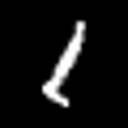
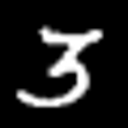
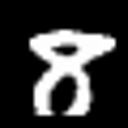
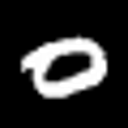
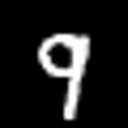
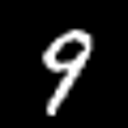
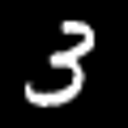
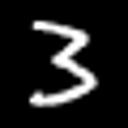
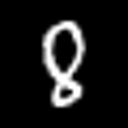
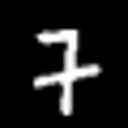
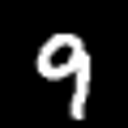
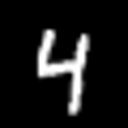
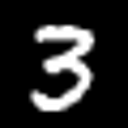
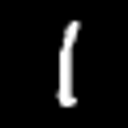
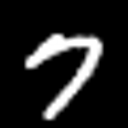
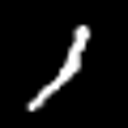

In [13]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

# Core logic

## Hyper Parameters

In [14]:
HP_SIGNAL_VEC_LEN = 1000 # aka SBV
HP_SIGNAL_VEC_NON_ZERO_BITS = 8
HP_SIGNAL_VEC_FEATURES_COUNT = 20
HP_SIGNAL_ENCODING = f'{HP_SIGNAL_VEC_LEN}/{HP_SIGNAL_VEC_NON_ZERO_BITS}'

HP_PIXEL_FEATURES_RANDOM_SEED = 42
HP_PIXEL_FEATURES_COUNT = 2_000

HP_POINTS_COUNT = 250_000
# HP_POINTS_COUNT = 100_000
HP_MAX_CLUSTER_SIZE = 40

## Types

In [15]:
class ClusterState(StrEnum):
    DEAD = auto()
    LEARN = auto()
    PROD_CANDIDATE = auto()
    PROD_WORK = auto()
    PROD_ETERNAL = auto()

# Constant or slow changing props. Frequently changed (hot track) props reside in sidecars
class ClusterMeta:
    def __init__(self, cluster_ind):
        self.state = ClusterState.LEARN
        self.cluster_ind = cluster_ind
        self.cluster_key = ()
        self.output_bit = 999_999_999
        self.input_bits = ()
        self.ones_count = -1
        self.last_activity_cycle = -1
        self.accuracy_calc = None
        self.verify_signal_ids = []

## Memory

In [16]:
def hdv_array_log_like_grow_policy(size):
    k = math.log(size, 100_000)
    new_size = size * 2 if k < 1 else size * 1.1
    return int(new_size)

def gc_memory():
    gc.collect()
    
    if cp.cuda.is_available():
        cp.get_default_memory_pool().free_all_blocks()

## Lambdas, Minifuncs, etc.

In [17]:
fetch_si_xy = lambda si: (si.x, si.y)
get_sequence = lambda sequences: np.array(list(itertools.chain.from_iterable(sequences)))
get_sequences_reading = lambda sequences, seq_reading_code: list(map(lambda r: sequences[r[0]] if r[1] == 0 else list(reversed(sequences[r[0]])), seq_reading_code))
get_xy_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: fetch_si_xy(si_ind_dict[si_ind]), sequence)))
get_raw_image = lambda image_id: Image.open(io.BytesIO((df_train_images if image_id < 100_000_000 else df_test_images).loc[image_id]['png']))

get_cluster_key = lambda output_bit, input_bits: (int(output_bit), tuple(map(int, sorted(input_bits))))

bundle_sbvs = lambda sbvs: np.where(sbvs.sum(axis=0), 1, 0).astype('i') # aka bloom filter
debundle_sbv = lambda sbv, sbv_dict_array, non_zero_bits: (sbv_dict_array @ sbv) == non_zero_bits

# NZV = non-zero bits, e.g. [2, 3, 8]
# SBV = sparsed binary vector, e.g. [0, 0, 1, 1, 0, 0, 0, 0, 1, 0]
def nzb_to_sbv(nzb, sbv_len):
    vec = np.zeros(sbv_len, dtype='i')
    vec[nzb] = 1
    return vec

sbv_to_nzb = lambda sbv: list(map(int, np.flatnonzero(sbv)))

# OHE = one-hot encoding
def xy_list_to_ohe_vec(xy_list):
    valid_boolmap = np.all(((xy_list >= 0) & (xy_list < config.sample_size)), axis=1)
    xy_list = xy_list[valid_boolmap]
    inds = xy_list @ np.array([1, config.sample_size])
    vec = np.zeros(config.sample_size ** 2, dtype='f')
    vec[inds] = 1
    return vec

def interval_governeur(interval, fun):
    assert interval >= 0
    countdown = interval
    
    def call(is_forced=False):
        nonlocal countdown

        if countdown <= 0 or is_forced:
            fun()
            countdown = interval
        
        countdown -= 1

    return call

def ensure_dtype(a, dt):
    assert a.dtype == dt, (a.dtype, dt)
    return a

def ensure_shape(a, shape):
    assert a.shape == shape, (a.shape, shape)
    return a

def ensure_len(a, l):
    assert len(a) == l, (len(a), l)
    return a

## Average Filters

In [18]:
# https://youtu.be/HCd-leV8OkU?t=1240
class AverageFilter:
    def __init__(self):
        self.value = 0 # aka prev_average
        self.n = 0

    def __call__(self, x):
        self.n += 1
        alpha = (self.n - 1) / self.n
        result = alpha * self.value + (1 - alpha) * x
        self.value = result
        return result

In [19]:
a = 1 + np.arange(9)
f = AverageFilter()
avg = f(a[0])
assert np.isclose(avg, 1)
assert np.isclose(avg, f.value)

for x in a[1:]:
    avg = f(x)
    assert np.isclose(avg, f.value)

assert np.isclose(avg, 5)
assert np.isclose(avg, f.value)

In [20]:
# https://www.youtube.com/watch?v=HCd-leV8OkU&t=583s
# https://read.nxtbook.com/ieee/signal_processing/signal_processing_nov_2023/implementing_moving_average_f.html
class MovingAverageFilter:
    def __init__(self, n):
        assert n >= 1
        self.n = n
        self.prev_average = 0
        self.value = 0 
        self.x_queue = deque()

    def __call__(self, x):
        self.x_queue.append(x)

        while len(self.x_queue) > (self.n + 1):
            self.x_queue.popleft()

        x_old = self.x_queue[0] if len(self.x_queue) > self.n else 0
        result = self.prev_average + (x - x_old) / self.n
        self.prev_average = result

        if len(self.x_queue) < (self.n + 1):
            result = result * self.n / len(self.x_queue)

        self.value = result
        return result

In [21]:
a = np.array([55, 60, 19, 80, 30, 19, 57, 26, 36, 78, 70, 34,  5, 65, 22, 10, 53,
       28, 98,  1, 67, 94, 29, 37, 87, 98, 39, 71, 98, 68, 47, 20, 15, 13,
        3, 83, 43, 86, 95, 21,  3, 64, 20, 97, 47, 15, 78, 20, 80, 75, 31,
       11, 24, 54, 53, 42, 44,  8,  1, 74, 47, 63,  5, 34, 89, 72, 95, 17,
       69, 67, 57, 42,  2, 81, 67, 41, 14, 25, 74, 59, 78,  1, 75, 15,  7,
       70, 68, 36, 60, 46, 81,  2, 34, 39, 71, 42, 30, 48, 26, 86])
f = MovingAverageFilter(10)
avg = f(a[0])
assert np.isclose(avg, a[0])
assert np.isclose(avg, f.value)

for x in a[1:]:
    avg = f(x)
    assert np.isclose(avg, f.value)

assert np.isclose(avg, 45.9)
assert np.isclose(avg, f.value)

## Pixel Features

In [22]:
rng_for_pixel_features = np.random.default_rng(HP_PIXEL_FEATURES_RANDOM_SEED)

In [23]:
class PixelFeature:
    def __init__(self, x, y, radius, bitmap_mask, dist_mask):
        self.x = x
        self.y = y
        self.radius = radius
        self.bitmap_mask = bitmap_mask
        self.dist_mask = dist_mask
        self.sbv = None

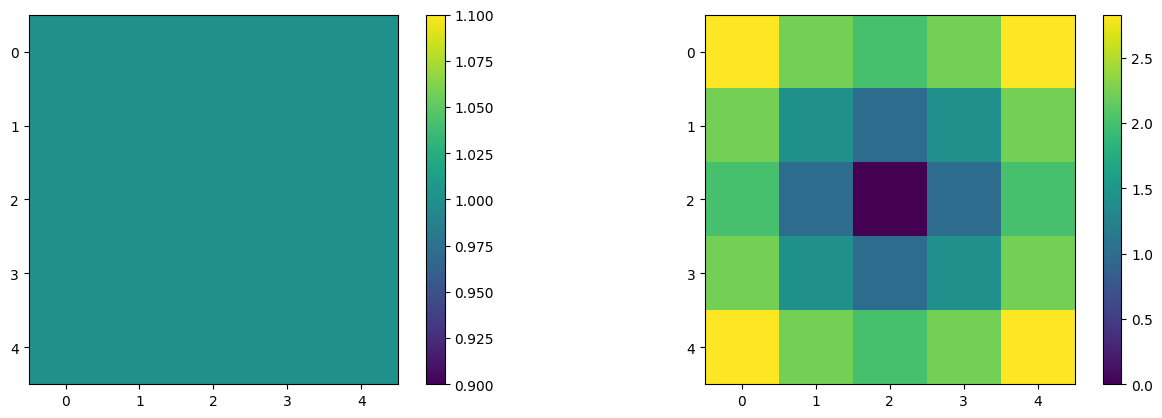

In [24]:
radius_to_pattern = {}
radius_to_dist_pattern = {} # config.sample_size if pixel if out of pattern, otherwise distance to center (within center distance = 0)

# for r in [3, 1]:
# for r in [5]:
# for r in [3]:
for r in [2]:
# for r in [1]:
    if r in [1, 2]:
        canvas = Image.new('1', size=(r * 2 + 1, r * 2 + 1), color='white')
    else:
        canvas = Image.new('1', size=(r * 2 + 1, r * 2 + 1), color='black')
        draw = ImageDraw.Draw(canvas)
        draw.circle([r, r], radius=r, outline='white', fill='white')

    pattern = np.array(canvas, dtype='f')
    radius_to_pattern[r] = pattern

    dist_pattern = np.zeros_like(pattern, dtype='f')
    
    for i in range(pattern.shape[0]):
        for j in range(pattern.shape[1]):
            dist = config.sample_size
            
            if pattern[i,j] != 0:
                vec = np.array([i - r, j - r])
                dist = np.linalg.norm(vec)
                assert dist < config.sample_size

            dist_pattern[i,j] = dist
    
    radius_to_dist_pattern[r] = dist_pattern

r = max(radius_to_pattern.keys())

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)
im = ax1.imshow(radius_to_pattern[r])
fig.colorbar(im, ax=ax1);
im = ax2.imshow(np.where(radius_to_dist_pattern[r] < config.sample_size, radius_to_dist_pattern[r], np.inf))
fig.colorbar(im, ax=ax2);

In [25]:
# n = 50_000
# xs = rng_for_pixel_features.integers(0, config.sample_size, size=n)
# ys = rng_for_pixel_features.integers(0, config.sample_size, size=n)
# radii = rng_for_pixel_features.choice(list(radius_to_pattern.keys()), size=n)
# xy_list = np.vstack([xs, ys]).T
# assert np.all(np.all((xy_list >= 0) & (xy_list < config.sample_size), axis=1))
# bitmap_padding = 0
# bitmap = np.zeros((config.sample_size + bitmap_padding * 2, config.sample_size + bitmap_padding * 2))
# pixel_features = []

# for xy, radius in zip(xy_list, radii):
#     pattern = radius_to_pattern[radius]
#     i0, j0 = bitmap_padding, bitmap_padding
#     i = i0 + xy[1]
#     j = j0 + xy[0]
#     i_lo = i - radius
#     i_hi = i + radius + 1
#     j_lo = j - radius
#     j_hi = j + radius + 1
    
#     if i_lo < 0 or j_lo < 0 or i_hi > config.sample_size or j_hi > config.sample_size:
#         continue
    
#     merge_site = bitmap[i_lo:i_hi,j_lo:j_hi]
#     merge_site_mask = np.where(merge_site != 0, 1, 0)
#     assert pattern.shape == merge_site.shape
#     overlap_ratio = np.where(pattern != 0, merge_site_mask, 0).sum() / pattern.sum()

#     # if overlap_ratio > 0.75:
#     # if overlap_ratio > 0.5:
#     # if overlap_ratio > 0.35:
#     if overlap_ratio > 0.25:
#     # if overlap_ratio > 0.0:
#         continue
    
#     # merge_site = np.where(pattern != 0, radius, merge_site)
#     merge_site = merge_site + pattern
#     bitmap[i-radius:i+radius+1,j-radius:j+radius+1] = merge_site
#     pixel_feature_bitmap_mask = np.zeros_like(bitmap, dtype='f')
#     pixel_feature_bitmap_mask[i_lo:i_hi,j_lo:j_hi] = pattern
#     pixel_feature_bitmap_mask = pixel_feature_bitmap_mask[bitmap_padding:bitmap_padding+config.sample_size, bitmap_padding:bitmap_padding+config.sample_size]
#     pixel_feature_dist_mask = np.full_like(bitmap, config.sample_size, dtype='f')
#     pixel_feature_dist_mask[i_lo:i_hi,j_lo:j_hi] = radius_to_dist_pattern[radius]
#     pixel_feature = PixelFeature(x=int(xy[0]), y=int(xy[1]), radius=radius, bitmap_mask=pixel_feature_bitmap_mask.ravel(), dist_mask=pixel_feature_dist_mask.ravel())
#     pixel_features.append(pixel_feature)

#     if len(pixel_features) >= HP_PIXEL_FEATURES_COUNT:
#         break
    
# bitmap = bitmap[bitmap_padding:bitmap_padding+config.sample_size, bitmap_padding:bitmap_padding+config.sample_size]

# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_figwidth(18)

# ax1.set_title(f'Pixel-Features Count={len(pixel_features)}, non-covered area={(bitmap == 0).sum() / (bitmap.shape[0] ** 2) * 100:.1f}%')
# im = ax1.imshow(bitmap, cmap='turbo')
# fig.colorbar(im, ax=ax1);

# random_pixel_feature_ind = rng_for_pixel_features.choice(len(pixel_features))
# ax2.set_title(f'Bitmap Mask of Pixel-Feature #{random_pixel_feature_ind}')
# im = ax2.imshow(vec_to_square_matrix(pixel_features[random_pixel_feature_ind].bitmap_mask), cmap='bwr')

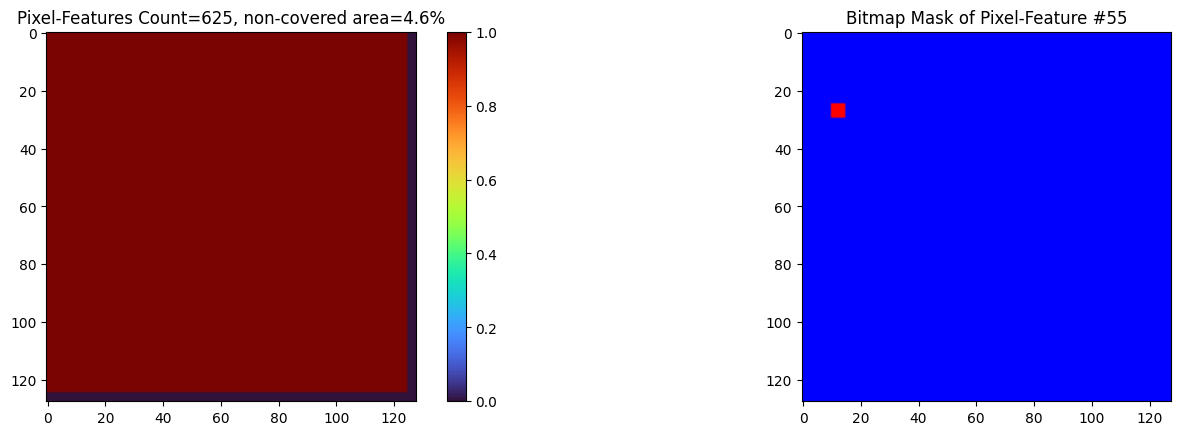

In [26]:
radius = max(radius_to_pattern.keys())

mgrid = np.mgrid[0:config.sample_size, 0:config.sample_size]
xs = mgrid[0].ravel()
ys = mgrid[1].ravel()
xy_list = np.vstack([xs, ys]).T
assert np.all(np.all((xy_list >= 0) & (xy_list < config.sample_size), axis=1))

bitmap_padding = 0
bitmap = np.zeros((config.sample_size + bitmap_padding * 2, config.sample_size + bitmap_padding * 2))
pixel_features = []

# for overlap in [0, 0.25, 0.5]:
for overlap in [0]:
    for xy in xy_list:
        if len(pixel_features) >= HP_PIXEL_FEATURES_COUNT:
            break
            
        if bitmap[xy[1], xy[0]] != 0:
            continue

        pattern = radius_to_pattern[radius]
        i0, j0 = bitmap_padding, bitmap_padding
        i = i0 + xy[1]
        j = j0 + xy[0]
        i_lo = i - radius
        i_hi = i + radius + 1
        j_lo = j - radius
        j_hi = j + radius + 1
        
        if i_lo < 0 or j_lo < 0 or i_hi > config.sample_size or j_hi > config.sample_size:
            continue
        
        merge_site = bitmap[i_lo:i_hi,j_lo:j_hi]
        merge_site_mask = np.where(merge_site != 0, 1, 0)
        assert pattern.shape == merge_site.shape
        overlap_ratio = np.where(pattern != 0, merge_site_mask, 0).sum() / pattern.sum()
    
        if overlap_ratio > overlap:
            continue
        
        merge_site = merge_site + pattern
        bitmap[i-radius:i+radius+1,j-radius:j+radius+1] = merge_site
        pixel_feature_bitmap_mask = np.zeros_like(bitmap, dtype='f')
        pixel_feature_bitmap_mask[i_lo:i_hi,j_lo:j_hi] = pattern
        pixel_feature_bitmap_mask = pixel_feature_bitmap_mask[bitmap_padding:bitmap_padding+config.sample_size, bitmap_padding:bitmap_padding+config.sample_size]
        pixel_feature_dist_mask = np.full_like(bitmap, config.sample_size, dtype='f')
        pixel_feature_dist_mask[i_lo:i_hi,j_lo:j_hi] = radius_to_dist_pattern[radius]
        pixel_feature = PixelFeature(x=int(xy[0]), y=int(xy[1]), radius=radius, bitmap_mask=pixel_feature_bitmap_mask.ravel(), dist_mask=pixel_feature_dist_mask.ravel())
        pixel_features.append(pixel_feature)
    
bitmap = bitmap[bitmap_padding:bitmap_padding+config.sample_size, bitmap_padding:bitmap_padding+config.sample_size]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(18)

ax1.set_title(f'Pixel-Features Count={len(pixel_features)}, non-covered area={(bitmap == 0).sum() / (bitmap.shape[0] ** 2) * 100:.1f}%')
im = ax1.imshow(bitmap, cmap='turbo')
fig.colorbar(im, ax=ax1);

random_pixel_feature_ind = rng_for_pixel_features.choice(len(pixel_features))
ax2.set_title(f'Bitmap Mask of Pixel-Feature #{random_pixel_feature_ind}')
im = ax2.imshow(vec_to_square_matrix(pixel_features[random_pixel_feature_ind].bitmap_mask), cmap='bwr')

In [27]:
df_pixel_features = pd.read_sql('SELECT x, y, radius, nzb FROM features WHERE encoding=:encoding AND type=:type', 
                                params={'encoding': HP_SIGNAL_ENCODING, 'type': 'pixel'}, con=transfs_db_con)
db_pixel_features_dict = dict(map(lambda p: ((p.x, p.y, p.radius), nzb_to_sbv(pickle.loads(p.nzb), HP_SIGNAL_VEC_LEN)), df_pixel_features.itertuples()))
unique_sbv_keys = set(map(lambda sbv: tuple(sorted(map(int, np.flatnonzero(sbv)))), db_pixel_features_dict.values()))
assert len(unique_sbv_keys) == len(db_pixel_features_dict)
print(f'Loaded {len(unique_sbv_keys)} pixel features')
new_pixel_features = []
linked_count = 0

for pf in pixel_features:
    key = (pf.x, pf.y, pf.radius)

    if key in db_pixel_features_dict:
        pf.sbv = db_pixel_features_dict[key]
        linked_count += 1
        continue
        
    attempts_to_generate_unique_sbv = 10
    sbv = np.zeros(HP_SIGNAL_VEC_LEN, dtype='f')

    for _ in range(attempts_to_generate_unique_sbv):
        ii = RNG.choice(HP_SIGNAL_VEC_LEN, HP_SIGNAL_VEC_NON_ZERO_BITS, replace=False)
        sbv_key = tuple(sorted(ii))

        if not sbv_key in unique_sbv_keys:
            sbv[ii] = 1
            unique_sbv_keys.add(sbv_key)
            break
    else:
        assert False, f'Failed to get unique SBV for pixel feature within {attempts_to_generate_unique_sbv} attempts'

    new_pixel_features.append(pf)
    pf.sbv = sbv

print(f'Linked {linked_count} pixel features')

if new_pixel_features:
    transfs_db_con.autocommit = False
    
    for pf in tqdm(new_pixel_features, desc='Persiting'):
        transfs_db_con.execute('INSERT INTO features(encoding, type, x, y, radius, bitmap_mask_nzb, nzb) VALUES (:encoding, :type, :x, :y, :radius, :bitmap_mask_nzb, :nzb)',
                               {
                                   'encoding': HP_SIGNAL_ENCODING, 
                                   'type': 'pixel', 
                                   'x': pf.x, 
                                   'y': pf.y, 
                                   'radius': pf.radius, 
                                   'bitmap_mask_nzb': pickle.dumps(sbv_to_nzb(pf.bitmap_mask)),
                                   'nzb': pickle.dumps(sbv_to_nzb(pf.sbv))
                               })

    transfs_db_con.autocommit = True
    print(f'Created and persisted {len(new_pixel_features)} new pixel features')

PIXEL_FEATURE_SBVS = np.array(list(map(lambda pf: pf.sbv, pixel_features)))
PIXEL_FEATURE_BITMAP_MASKS = np.array(list(map(lambda pf: pf.bitmap_mask, pixel_features)))
PIXEL_FEATURE_DIST_MASKS = np.array(list(map(lambda pf: pf.dist_mask, pixel_features)))
PIXEL_FEATURE_XY_ARRAY = np.array(list(map(lambda pf: (pf.x, pf.y), pixel_features)))

Loaded 3117 pixel features
Linked 625 pixel features


In [28]:
df_train_images_ = df_train_images.head(2000)
# df_train_images_ = df_train_images
gpu_pixel_feature_bitmap_masks = xp_array_to_gpu(PIXEL_FEATURE_BITMAP_MASKS)
PIXEL_FEATURE_FREQS = np.zeros(PIXEL_FEATURE_SBVS.shape[0], dtype='i')

for image in tqdm(df_train_images_.itertuples(), total=len(df_train_images_)):
    sequences = pickle.loads(image.inner_sequences)
    si_ind_dict = pickle.loads(image.inner_si_ind_dict)
    xy_list_full = get_xy_sequence(get_sequence(sequences), si_ind_dict)
    ohe_vec = xy_list_to_ohe_vec(xy_list_full)
    ohe_vec = xp_array_to_gpu(ohe_vec)
    pixel_feature_inds = np.flatnonzero(gpu_pixel_feature_bitmap_masks @ ohe_vec)
    pixel_feature_inds = xp_array_from_gpu(pixel_feature_inds)
    PIXEL_FEATURE_FREQS[pixel_feature_inds] += 1

ACTIVE_PIXEL_FEATURES_COUNT = np.count_nonzero(PIXEL_FEATURE_FREQS)

  0%|          | 0/2000 [00:00<?, ?it/s]

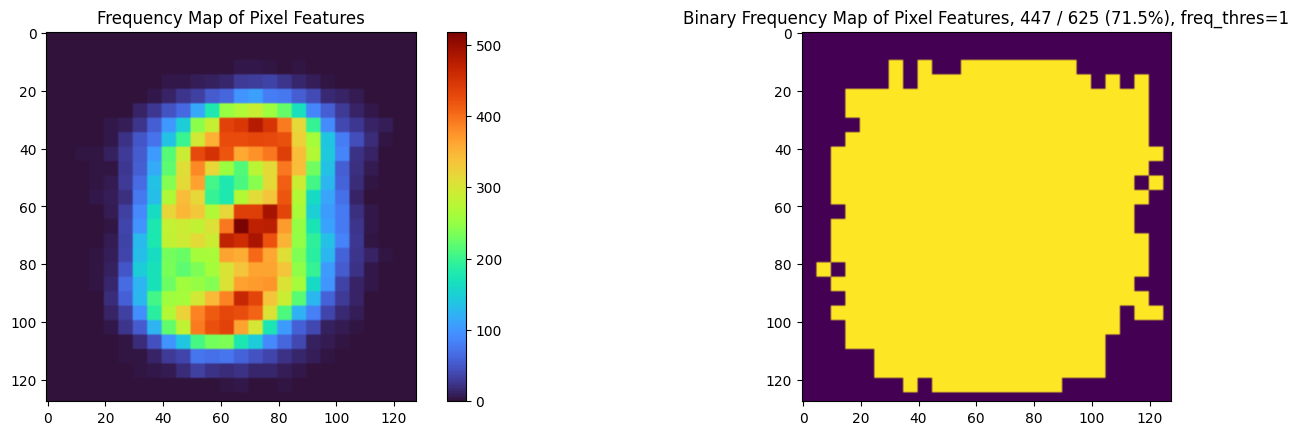

In [29]:
bitmap = np.zeros((config.sample_size, config.sample_size), dtype='i')
assert PIXEL_FEATURE_BITMAP_MASKS.shape[0] == PIXEL_FEATURE_FREQS.shape[0]

for mask, freq in zip(xp_array_from_gpu(PIXEL_FEATURE_BITMAP_MASKS), PIXEL_FEATURE_FREQS):
    mask_with_freq = np.where(mask, freq, 0)
    bitmap += mask_with_freq.reshape(bitmap.shape)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(18)

ax1.set_title(f'Frequency Map of Pixel Features')
im = ax1.imshow(bitmap, cmap='turbo')
fig.colorbar(im, ax=ax1)

pixel_feature_freqs_sorted_desc = -np.sort(-PIXEL_FEATURE_FREQS)
percentile = 1
ind = int(np.count_nonzero(pixel_feature_freqs_sorted_desc) * percentile)
freq_thres = pixel_feature_freqs_sorted_desc[ind-1]
# bitmap2 = np.where(bitmap, 1, 0)
bitmap2 = np.where(PIXEL_FEATURE_BITMAP_MASKS[(PIXEL_FEATURE_FREQS >= freq_thres)].sum(axis=0), 1, 0)
# bitmap2 = xp_array_from_gpu(bitmap2)
bitmap2 = vec_to_square_matrix(bitmap2)
# a = (PIXEL_FEATURE_FREQS > 0).sum()
a = (PIXEL_FEATURE_FREQS >= freq_thres).sum()
b = PIXEL_FEATURE_BITMAP_MASKS.shape[0]
ax2.set_title(f'Binary Frequency Map of Pixel Features, {a} / {b} ({a / b * 100:.1f}%), freq_thres={freq_thres}')
ax2.imshow(bitmap2);

## Transformations

In [30]:
def get_rotate_transf(deg):
    half_sz = config.sample_size / 2
    move_to_ooc_transf = np.array([
        [1, 0, -half_sz],
        [0, 1, -half_sz],
        [0, 0, 1]])
    theta = np.deg2rad(deg)
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    rotate_transf = np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta, cos_theta, 0],
        [0, 0, 1]
    ])
    move_to_target_loc_transf = np.array([
        [1, 0, half_sz],
        [0, 1, half_sz],
        [0, 0, 1]])
    return move_to_target_loc_transf @ rotate_transf @ move_to_ooc_transf

def get_offset_transf(dx=0, dy=0):
    return np.array([
        [1, 0, dx],
        [0, 1, dy],
        [0, 0, 1]])

In [31]:
transfs = {
    'offset_10_0': get_offset_transf(10, 0),
    'offset_1_0': get_offset_transf(1, 0),
    'offset_-1_0': get_offset_transf(-1, 0),
    'offset_0_1': get_offset_transf(0, 1),
    'offset_1_1': get_offset_transf(1, 1),
    'offset_5_0': get_offset_transf(5, 0),
    'rotate_45': get_rotate_transf(45),
    'rotate_90': get_rotate_transf(90),
}
TRANSF_CODE = 'rotate_45'
TRANSF = transfs[TRANSF_CODE]

## XY List <-> Pixel Features

In [32]:
def xy_list_to_pixel_feature_inds(xy_list):
    ohe_vec = xy_list_to_ohe_vec(xy_list)
    # ohe_vec = xp_array_to_gpu(ohe_vec)
    inds = np.flatnonzero(PIXEL_FEATURE_BITMAP_MASKS @ ohe_vec)
    # return xp_array_from_gpu(inds)
    return inds

def xy_list_to_nearest_pixel_feature_inds(xy_list):
    valid_boolmap = np.all(((xy_list >= 0) & (xy_list < config.sample_size)), axis=1)
    xy_list = xy_list[valid_boolmap]
    inds = xy_list @ np.array([1, config.sample_size])
    vecs = np.zeros((inds.shape[0], config.sample_size ** 2), dtype='f')

    for i, j in enumerate(inds):
        vecs[i,j] = 1

    # compute matrix where rows correspond to xy pairs and columns correspond to pixel features
    # value in cell [i,j] == dist_from_xy[i]_to_center_of_pixel_feature[j]
    mat = vecs @ PIXEL_FEATURE_DIST_MASKS.T
    # for each xy get index of pixel feature which has minimal distance to center of pixel feature
    t = np.argmin(mat, axis=1)
    # if row consists of dists which exceed config.sample_size then np.argmin has no sense for such row (it means that there is no match with any pixel feature),
    # as such - exclude such row from consideration
    rows_with_good_values_boolmap = np.any(mat < config.sample_size, axis=1)
    t = t[rows_with_good_values_boolmap]
    return np.unique(t)

## Signals Generator

In [33]:
SignalsGeneratorResult = namedtuple('SignalsGeneratorResult', 
                                    ['signals_input', 'signals_output', # SBV
                                     'signal_ids', 
                                     'signal_xy_lists_input', 'signal_xy_lists_output', 
                                     'xy_list_full'])
DummySignalsGeneratorResult = lambda: SignalsGeneratorResult([], [], [], [], [], [])

### RealImageSignalsGenerator

In [34]:
# For each image generate number of signals (image_variants_count) by randomly select of si_ind and convert this si_ind to pixel features
class RealImageSignalsGenerator:
    def __init__(self, transf, signals_count, image_variants_count, logger=lambda m: True):
        self.transf = transf
        self.signals_count = signals_count
        assert image_variants_count > 0
        self.image_variants_count = image_variants_count

        self.image_id = -1
        self.image_variants_count_for_image_id = 0
        self.image_variants_generated = 0
        self.xy_list_full = []
        self.xy_list_inds_count = -1
        
    def __call__(self):
        signals_input = []
        signals_output = []
        signal_ids = []
        signal_xy_lists_input = []
        signal_xy_lists_output = []

        while len(signals_input) < self.signals_count:
            if self.image_id == -1 or self.image_variants_generated >= self.image_variants_count_for_image_id:
                # the very first call or variants of current image are exhausted, switch to next image
                self.image_id = int(RNG.choice(df_train_images.index))
                self.image_variants_generated = 0
                image = df_train_images.loc[self.image_id]
                # pickle.loads consumes almost 50% of the time of execution of generate() :=(
                sequences = pickle.loads(image.inner_sequences)
                si_ind_dict = pickle.loads(image.inner_si_ind_dict)
                xy_list_full = get_xy_sequence(get_sequence(sequences), si_ind_dict)
                self.xy_list_full = xy_list_full
                
                xy_list_inds_count = min(xy_list_full.shape[0], HP_SIGNAL_VEC_FEATURES_COUNT)
                xy_list_combinations_count = math.comb(xy_list_full.shape[0], xy_list_inds_count)

                if xy_list_combinations_count >= self.image_variants_count:
                    self.xy_list_inds_count = xy_list_inds_count
                    self.image_variants_count_for_image_id = self.image_variants_count
                else:
                    assert xy_list_inds_count > 0
                    xy_list_inds_count_to_combinations_count = Counter()
                
                    for inds_count in range(xy_list_inds_count, 0, -1):
                        xy_list_inds_count_to_combinations_count[inds_count] = math.comb(xy_list_full.shape[0], inds_count)

                    xy_list_inds_count_with_most_variants = xy_list_inds_count_to_combinations_count.most_common(1)[0]
                    self.xy_list_inds_count = xy_list_inds_count_with_most_variants[0]
                    self.image_variants_count_for_image_id = min(self.image_variants_count, xy_list_inds_count_with_most_variants[1])
            
                self.xy_list_inds_count > 0
                self.xy_list_inds_count <= self.xy_list_full.shape[0]
                assert self.image_variants_count_for_image_id > 0, self.image_variants_count_for_image_id
                assert self.image_variants_count_for_image_id <= self.image_variants_count, self.image_variants_count_for_image_id

            xy_list_inds = RNG.choice(self.xy_list_full.shape[0], self.xy_list_inds_count, replace=False)
            xy_list_origin = self.xy_list_full[xy_list_inds]
            ###
            xy_list_origin = PIXEL_FEATURE_XY_ARRAY[xy_list_to_pixel_feature_inds(xy_list_origin)]
            ###
            xy_list_transf = np.hstack([xy_list_origin, np.ones(xy_list_origin.shape[0])[:,np.newaxis]]) # make homogeneous coords
            xy_list_transf = (self.transf @ xy_list_transf.T).T[:,:2]
            xy_list_transf = np.round(xy_list_transf, decimals=0).astype(int)
            xy_list_origin_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[xy_list_to_pixel_feature_inds(xy_list_origin)])
            xy_list_transf_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[xy_list_to_pixel_feature_inds(xy_list_transf)])
            assert xy_list_origin_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            assert xy_list_transf_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            
            self.image_variants_generated += 1
            signals_input.append(xy_list_origin_sbv)
            signals_output.append(xy_list_transf_sbv)
            signal_ids.append((self.image_id, tuple(map(int, sorted(xy_list_inds)))))
            signal_xy_lists_input.append(xy_list_origin)
            signal_xy_lists_output.append(xy_list_transf)

        assert len(signals_input) == len(signals_output)
        assert len(signals_input) == len(signal_ids)
        assert len(signals_input) == len(signal_xy_lists_input)
        assert len(signals_input) == len(signal_xy_lists_output)
        return SignalsGeneratorResult(signals_input=np.vstack(signals_input), 
                                      signals_output=np.vstack(signals_output), 
                                      signal_ids=signal_ids,
                                      signal_xy_lists_input=signal_xy_lists_input,
                                      signal_xy_lists_output=signal_xy_lists_output,
                                      xy_list_full=self.xy_list_full)

    def switch(self):
        pass

In [35]:
generator = RealImageSignalsGenerator(TRANSF, 100, 10)

In [36]:
%%time
sgr = generator()
signal_ind = 0

CPU times: user 7.14 s, sys: 10.2 ms, total: 7.15 s
Wall time: 115 ms


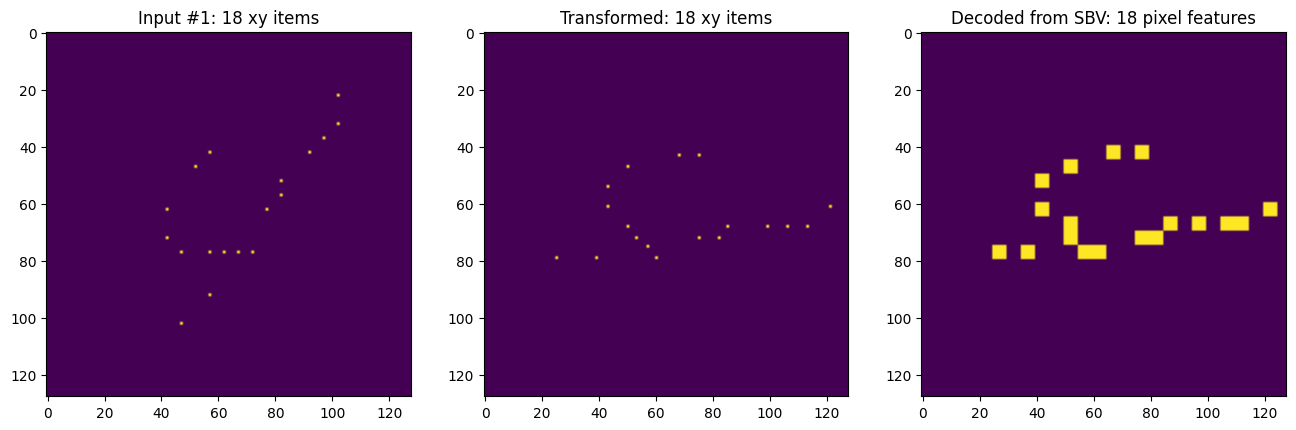

In [37]:
# signal_ind = RNG.choice(len(sgr.signals_output))
# signal_ind = 19
signal_ind = (signal_ind + 1) % len(sgr.signals_output)
pixel_feature_inds = debundle_sbv(sgr.signals_output[signal_ind], PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)
bm_output = PIXEL_FEATURE_BITMAP_MASKS[pixel_feature_inds].sum(axis=0)
bm_output = xp_array_from_gpu(bm_output)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(16)
ax1.set_title(f'Input #{signal_ind}: {sgr.signal_xy_lists_input[signal_ind].shape[0]} xy items')
ax1.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_input[signal_ind])))
ax2.set_title(f'Transformed: {sgr.signal_xy_lists_output[signal_ind].shape[0]} xy items')
ax2.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_output[signal_ind])))
ax3.set_title(f'Decoded from SBV: {np.count_nonzero(pixel_feature_inds)} pixel features')
ax3.imshow(vec_to_square_matrix(bm_output));

### FixedPixelFeatureSignalsGenerator

In [38]:
# one pixel feature is fixed for a number calls (fixation period) and remaining features are randomly picked according to their frequency
class FixedPixelFeatureSignalsGenerator:
    def __init__(self, transf, signals_count, fixation_period, logger=lambda m: True):
        self.transf = transf
        self.signals_count = signals_count
        assert fixation_period > 0
        self.fixation_period = fixation_period
        self.fixation_countdown = self.fixation_period
        self.fixed_pixel_feature_ind = -1
        self.pixel_feature_inds_sorted_by_freq_desc = np.argsort(-PIXEL_FEATURE_FREQS)
        # strip pixel features which have zero freqs, i.o.w. leave only those with nonzero
        active_pixel_features_count = np.count_nonzero(PIXEL_FEATURE_FREQS)
        assert active_pixel_features_count > 0
        self.pixel_feature_inds_sorted_by_freq_desc = self.pixel_feature_inds_sorted_by_freq_desc[:active_pixel_features_count]
        assert self.pixel_feature_inds_sorted_by_freq_desc.shape[0] == active_pixel_features_count
        self.pixel_feature_inds = np.arange(PIXEL_FEATURE_SBVS.shape[0])
        
    def __call__(self):
        signals_input = [] # SBV
        signals_output = [] # SBV
        signal_ids = []
        signal_xy_lists_input = []
        signal_xy_lists_output = []

        while len(signals_input) < self.signals_count:
            if self.fixed_pixel_feature_ind == -1 or self.fixation_countdown <= 0:
                self.fixed_pixel_feature_ind = self.pixel_feature_inds_sorted_by_freq_desc[0]
                self.pixel_feature_inds_sorted_by_freq_desc = np.roll(self.pixel_feature_inds_sorted_by_freq_desc, -1)
                # temporarily ban fixed pixel feature from being picked up as a free one
                self.free_pixel_feature_probs = PIXEL_FEATURE_FREQS[:].astype('f')
                self.free_pixel_feature_probs[self.fixed_pixel_feature_ind] = 0
                self.free_pixel_feature_probs /= self.free_pixel_feature_probs.sum()
                self.fixation_countdown = self.fixation_period

            assert self.fixed_pixel_feature_ind != -1
            # pick up remaining pixel feature (via their probabilities) excluding fixed pixel feature
            free_pixel_feature_inds = RNG.choice(self.pixel_feature_inds, HP_SIGNAL_VEC_FEATURES_COUNT-1, p=self.free_pixel_feature_probs, replace=False)
            pixel_feature_inds_input = np.hstack([self.fixed_pixel_feature_ind, free_pixel_feature_inds])
            assert pixel_feature_inds_input.shape[0] == HP_SIGNAL_VEC_FEATURES_COUNT

            xy_list_input = PIXEL_FEATURE_XY_ARRAY[pixel_feature_inds_input]
            xy_list_transf = np.hstack([xy_list_input, np.ones(xy_list_input.shape[0])[:,np.newaxis]]) # make homogeneous coords
            xy_list_transf = (self.transf @ xy_list_transf.T).T[:,:2]
            xy_list_transf = np.round(xy_list_transf, decimals=0).astype(int)
            # pixel_feature_inds_output = xy_list_to_nearest_pixel_feature_inds(xy_list_transf) # must be used when there is overlap among pixel features
            # pixel_feature_inds_output = xy_list_to_pixel_feature_inds(xy_list_transf) # can be used when there is no overlap among pixel features
            pixel_feature_inds_output = xy_list_to_pixel_feature_inds(xy_list_transf) # can be used when there is no overlap among pixel features
            xy_list_output = PIXEL_FEATURE_XY_ARRAY[pixel_feature_inds_output]
            xy_list_input_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[pixel_feature_inds_input])
            xy_list_output_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[pixel_feature_inds_output])
            assert xy_list_input_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            assert xy_list_output_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            self.fixation_countdown -= 1
            
            signals_input.append(xy_list_input_sbv)
            signals_output.append(xy_list_output_sbv)
            signal_ids.append(tuple(map(int, sorted(pixel_feature_inds_input))))
            signal_xy_lists_input.append(xy_list_input)
            signal_xy_lists_output.append(xy_list_output)

        assert len(signals_input) == len(signals_output)
        assert len(signals_input) == len(signal_ids)
        assert len(signals_input) == len(signal_xy_lists_input)
        assert len(signals_input) == len(signal_xy_lists_output)
        return SignalsGeneratorResult(signals_input=np.vstack(signals_input), 
                                      signals_output=np.vstack(signals_output),
                                      signal_ids=signal_ids,
                                      signal_xy_lists_input=signal_xy_lists_input,
                                      signal_xy_lists_output=signal_xy_lists_output,
                                      xy_list_full=[])

    def switch(self):
        pass

In [39]:
generator = FixedPixelFeatureSignalsGenerator(TRANSF, 100, 10)

In [40]:
%%time
sgr = generator()
signal_ind = 0

CPU times: user 4.5 s, sys: 1.54 ms, total: 4.5 s
Wall time: 71.5 ms


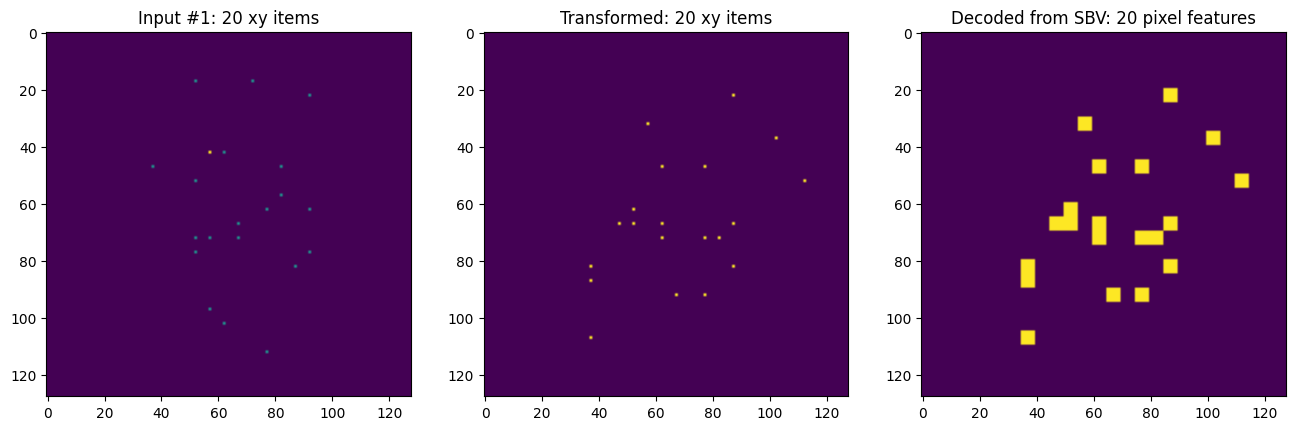

In [41]:
# signal_ind = RNG.choice(len(sgr.signals_output))
# signal_ind = 19
signal_ind = (signal_ind + 1) % len(sgr.signals_output)
pixel_feature_inds = debundle_sbv(sgr.signals_output[signal_ind], PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)
bm_output = PIXEL_FEATURE_BITMAP_MASKS[pixel_feature_inds].sum(axis=0)
bm_output = xp_array_from_gpu(bm_output)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(16)
ax1.set_title(f'Input #{signal_ind}: {sgr.signal_xy_lists_input[signal_ind].shape[0]} xy items')
t = xy_list_to_ohe_vec(sgr.signal_xy_lists_input[signal_ind])
t[PIXEL_FEATURE_XY_ARRAY[generator.fixed_pixel_feature_ind] @ [1, config.sample_size]] = 2
ax1.imshow(vec_to_square_matrix(t))
ax2.set_title(f'Transformed: {sgr.signal_xy_lists_output[signal_ind].shape[0]} xy items')
ax2.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_output[signal_ind])))
ax3.set_title(f'Decoded from SBV: {np.count_nonzero(pixel_feature_inds)} pixel features')
ax3.imshow(vec_to_square_matrix(bm_output));

### RollingPixelFeatureSignalsGenerator

In [42]:
# On every call specified number (fresh_count) of pixel features is replaced with a fresh ones
class RollingPixelFeatureSignalsGenerator:
    def __init__(self, transf, signals_count, fresh_count, logger=lambda m: True):
        self.transf = transf
        self.signals_count = signals_count
        assert fresh_count > 0
        self.fresh_count = fresh_count
        self.pixel_feature_inds_fifo = np.array([])
        self.pixel_feature_inds_set = set()
        self.pixel_feature_probs = PIXEL_FEATURE_FREQS[:].astype('f')
        self.pixel_feature_probs /= self.pixel_feature_probs.sum()
        self.pixel_features_count = PIXEL_FEATURE_FREQS.shape[0]
        
    def __call__(self):
        signals_input = [] # SBV
        signals_output = [] # SBV
        signal_ids = []
        signal_xy_lists_input = []
        signal_xy_lists_output = []

        while len(signals_input) < self.signals_count:
            if self.pixel_feature_inds_fifo.shape[0] == 0:
                self.pixel_feature_inds_fifo = RNG.choice(self.pixel_features_count, HP_SIGNAL_VEC_FEATURES_COUNT, p=self.pixel_feature_probs, replace=False)
                self.pixel_feature_inds_set = set(self.pixel_feature_inds_fifo)
            else:
                fresh_pixel_features_gathered = 0
                
                for _ in range(self.fresh_count):
                    for _ in range(self.pixel_features_count):
                        new_pixel_feature_ind = RNG.choice(self.pixel_features_count, p=self.pixel_feature_probs)

                        if not new_pixel_feature_ind in self.pixel_feature_inds_set:
                            self.pixel_feature_inds_fifo = np.hstack([self.pixel_feature_inds_fifo, new_pixel_feature_ind])
                            self.pixel_feature_inds_set.add(new_pixel_feature_ind)
                            fresh_pixel_features_gathered += 1
                            break
                    else:
                        # failed to find new pixel feature ind which is not within self.pixel_feature_inds_fifo, =(
                        # maybe next call will be more successful...
                        pass

                assert fresh_pixel_features_gathered >=0 and fresh_pixel_features_gathered <= self.fresh_count, fresh_pixel_features_gathered
                removed_pixel_feature_inds = self.pixel_feature_inds_fifo[:fresh_pixel_features_gathered]
                self.pixel_feature_inds_fifo = self.pixel_feature_inds_fifo[fresh_pixel_features_gathered:]
                for ind in removed_pixel_feature_inds: self.pixel_feature_inds_set.remove(ind)

            pixel_feature_inds_input = self.pixel_feature_inds_fifo
            xy_list_input = PIXEL_FEATURE_XY_ARRAY[pixel_feature_inds_input]
            xy_list_transf = np.hstack([xy_list_input, np.ones(xy_list_input.shape[0])[:,np.newaxis]]) # make homogeneous coords
            xy_list_transf = (self.transf @ xy_list_transf.T).T[:,:2]
            xy_list_transf = np.round(xy_list_transf, decimals=0).astype(int)
            # pixel_feature_inds_output = xy_list_to_nearest_pixel_feature_inds(xy_list_transf) # must be used when there is overlap among pixel features
            # pixel_feature_inds_output = xy_list_to_pixel_feature_inds(xy_list_transf) # can be used when there is no overlap among pixel features
            pixel_feature_inds_output = xy_list_to_pixel_feature_inds(xy_list_transf) # can be used when there is no overlap among pixel features
            xy_list_output = PIXEL_FEATURE_XY_ARRAY[pixel_feature_inds_output]
            xy_list_input_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[pixel_feature_inds_input])
            xy_list_output_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[pixel_feature_inds_output])
            assert xy_list_input_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            assert xy_list_output_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            
            signals_input.append(xy_list_input_sbv)
            signals_output.append(xy_list_output_sbv)
            signal_ids.append(tuple(map(int, sorted(pixel_feature_inds_input))))
            signal_xy_lists_input.append(xy_list_input)
            signal_xy_lists_output.append(xy_list_output)

        assert len(signals_input) == len(signals_output)
        assert len(signals_input) == len(signal_ids)
        assert len(signals_input) == len(signal_xy_lists_input)
        assert len(signals_input) == len(signal_xy_lists_output)
        return SignalsGeneratorResult(signals_input=np.vstack(signals_input), 
                                      signals_output=np.vstack(signals_output),
                                      signal_ids=signal_ids,
                                      signal_xy_lists_input=signal_xy_lists_input,
                                      signal_xy_lists_output=signal_xy_lists_output,
                                      xy_list_full=[])

    def switch(self):
        pass

In [43]:
generator = RollingPixelFeatureSignalsGenerator(TRANSF, 100, 1)

In [44]:
%%time
sgr = generator()
signal_ind = 0

CPU times: user 3.61 s, sys: 40 μs, total: 3.61 s
Wall time: 58.1 ms


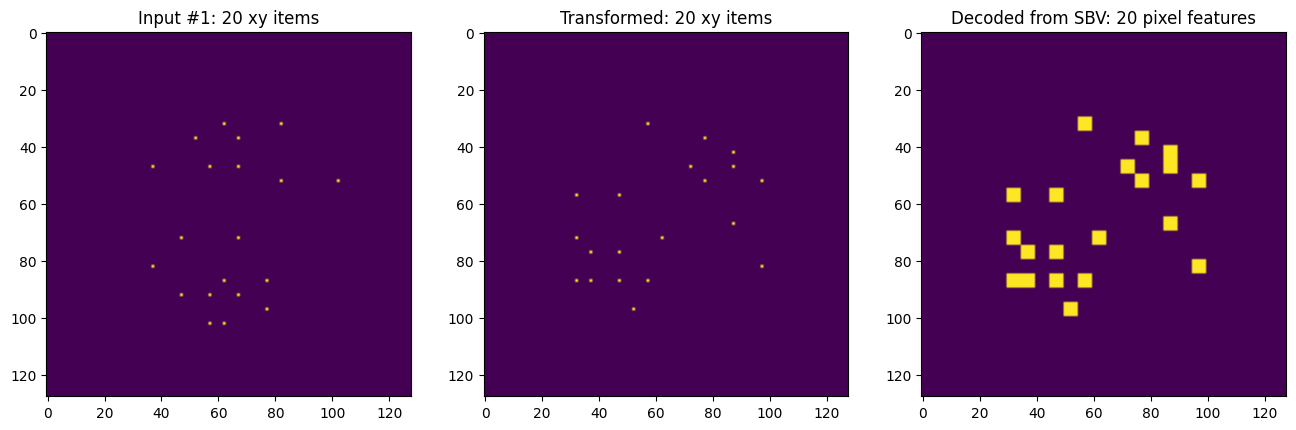

In [45]:
signal_ind = (signal_ind + 1) % len(sgr.signals_output)
pixel_feature_inds = debundle_sbv(sgr.signals_output[signal_ind], PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)
bm_output = PIXEL_FEATURE_BITMAP_MASKS[pixel_feature_inds].sum(axis=0)
bm_output = xp_array_from_gpu(bm_output)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(16)
ax1.set_title(f'Input #{signal_ind}: {sgr.signal_xy_lists_input[signal_ind].shape[0]} xy items')
ax1.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_input[signal_ind])))
ax2.set_title(f'Transformed: {sgr.signal_xy_lists_output[signal_ind].shape[0]} xy items')
ax2.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_output[signal_ind])))
ax3.set_title(f'Decoded from SBV: {np.count_nonzero(pixel_feature_inds)} pixel features')
ax3.imshow(vec_to_square_matrix(bm_output));

### PooledPixelFeatureSignalsGenerator

In [46]:
# Create pool of pixel features of designated size (pool_size) and sample signals from that pool. 
# Recreate pool on switch call
class PooledPixelFeatureSignalsGenerator:
    def __init__(self, transf, signals_count, pool_size, logger=lambda m: True):
        self.logger = logger
        self.transf = transf
        self.signals_count = signals_count
        assert pool_size >= HP_SIGNAL_VEC_FEATURES_COUNT
        self.pool_size = pool_size
        self.pooled_pixel_feature_inds = np.array([])
        self.pixel_feature_inds_sorted_by_freq_desc = np.argsort(-PIXEL_FEATURE_FREQS)
        # strip pixel features which have zero freqs, i.o.w. leave only those with nonzero
        active_pixel_features_count = np.count_nonzero(PIXEL_FEATURE_FREQS)
        assert active_pixel_features_count > 0
        self.pixel_feature_inds_sorted_by_freq_desc = self.pixel_feature_inds_sorted_by_freq_desc[:active_pixel_features_count]
        assert self.pixel_feature_inds_sorted_by_freq_desc.shape[0] == active_pixel_features_count
        self.switch()
        
    def __call__(self):
        signals_input = [] # SBV
        signals_output = [] # SBV
        signal_ids = []
        signal_xy_lists_input = []
        signal_xy_lists_output = []

        while len(signals_input) < self.signals_count:
            pixel_feature_inds_input = RNG.choice(self.pooled_pixel_feature_inds, HP_SIGNAL_VEC_FEATURES_COUNT, replace=False)
            xy_list_input = PIXEL_FEATURE_XY_ARRAY[pixel_feature_inds_input]
            xy_list_transf = np.hstack([xy_list_input, np.ones(xy_list_input.shape[0])[:,np.newaxis]]) # make homogeneous coords
            xy_list_transf = (self.transf @ xy_list_transf.T).T[:,:2]
            xy_list_transf = np.round(xy_list_transf, decimals=0).astype(int)
            # pixel_feature_inds_output = xy_list_to_nearest_pixel_feature_inds(xy_list_transf) # must be used when there is overlap among pixel features
            pixel_feature_inds_output = xy_list_to_pixel_feature_inds(xy_list_transf) # can be used when there is no overlap among pixel features
            xy_list_output = PIXEL_FEATURE_XY_ARRAY[pixel_feature_inds_output]
            xy_list_input_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[pixel_feature_inds_input])
            xy_list_output_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[pixel_feature_inds_output])
            assert xy_list_input_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            assert xy_list_output_sbv.shape[0] == HP_SIGNAL_VEC_LEN

            signals_input.append(xy_list_input_sbv)
            signals_output.append(xy_list_output_sbv)
            signal_ids.append(tuple(map(int, sorted(pixel_feature_inds_input))))
            signal_xy_lists_input.append(xy_list_input)
            signal_xy_lists_output.append(xy_list_output)

        assert len(signals_input) == len(signals_output)
        assert len(signals_input) == len(signal_ids)
        assert len(signals_input) == len(signal_xy_lists_input)
        assert len(signals_input) == len(signal_xy_lists_output)
        return SignalsGeneratorResult(signals_input=np.vstack(signals_input), 
                                      signals_output=np.vstack(signals_output),
                                      signal_ids=signal_ids,
                                      signal_xy_lists_input=signal_xy_lists_input,
                                      signal_xy_lists_output=signal_xy_lists_output,
                                      xy_list_full=[])

    def switch(self):
        self.pooled_pixel_feature_inds = self.pixel_feature_inds_sorted_by_freq_desc[:self.pool_size]
        self.pixel_feature_inds_sorted_by_freq_desc = np.roll(self.pixel_feature_inds_sorted_by_freq_desc, -self.pool_size)
        l = self.pooled_pixel_feature_inds[0]
        h = self.pooled_pixel_feature_inds[-1]
        self.logger(f'Pool inds=[{l}, ..., {h}], freqs=[{PIXEL_FEATURE_FREQS[l]}, ..., {PIXEL_FEATURE_FREQS[h]}]')
        assert self.pooled_pixel_feature_inds.shape[0] >= HP_SIGNAL_VEC_FEATURES_COUNT

In [47]:
generator = PooledPixelFeatureSignalsGenerator(TRANSF, 100, 30, logger=lambda m: print(m))

Pool inds=[338, ..., 308], freqs=[518, ..., 418]


In [48]:
%%time
sgr = generator()
signal_ind = 0

CPU times: user 3.1 s, sys: 91 μs, total: 3.1 s
Wall time: 49.5 ms


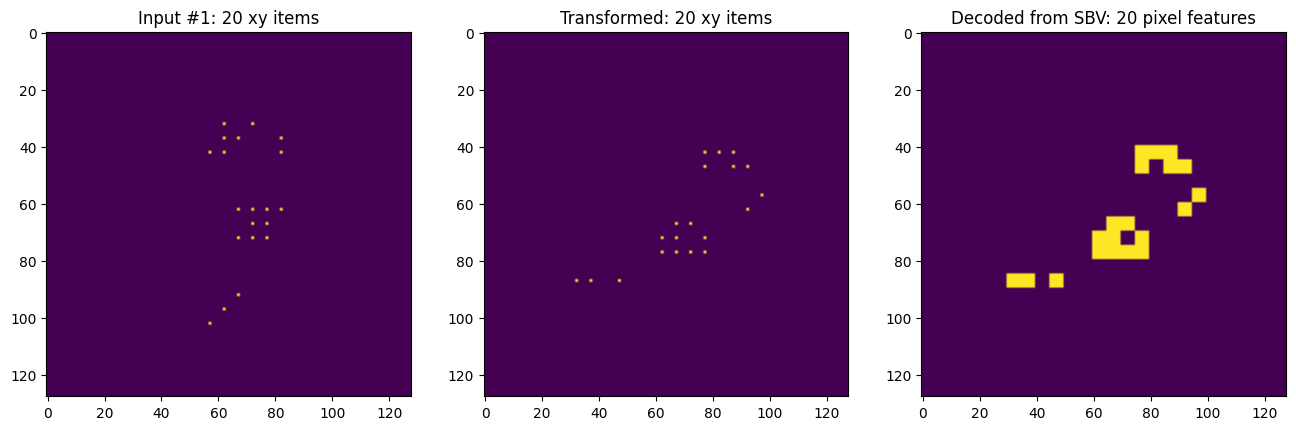

In [49]:
signal_ind = (signal_ind + 1) % len(sgr.signals_output)
pixel_feature_inds = debundle_sbv(sgr.signals_output[signal_ind], PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)
bm_output = PIXEL_FEATURE_BITMAP_MASKS[pixel_feature_inds].sum(axis=0)
bm_output = xp_array_from_gpu(bm_output)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(16)
ax1.set_title(f'Input #{signal_ind}: {sgr.signal_xy_lists_input[signal_ind].shape[0]} xy items')
ax1.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_input[signal_ind])))
ax2.set_title(f'Transformed: {sgr.signal_xy_lists_output[signal_ind].shape[0]} xy items')
ax2.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_output[signal_ind])))
ax3.set_title(f'Decoded from SBV: {np.count_nonzero(pixel_feature_inds)} pixel features')
ax3.imshow(vec_to_square_matrix(bm_output));

### AsyncSignalsGenerator

In [50]:
@dataclass
class AsyncSignalsGeneratorTask:
    task_id: int
    op: str
    params: dict = None

@dataclass
class AsyncSignalsGeneratorTaskResult:
    task_id: int
    payload: typing.Any = None

def async_signals_generator_fun(generator_typename, inp_queue, out_queue, *args):
    LOG.app_name = 'HOST_ASG'
    LOG(f'Starting host for async signals generator {generator_typename}')

    match generator_typename:
        case RealImageSignalsGenerator.__name__:
            generator = RealImageSignalsGenerator(*args, logger=LOG)
        case FixedPixelFeatureSignalsGenerator.__name__:
            generator = FixedPixelFeatureSignalsGenerator(*args, logger=LOG)
        case RollingPixelFeatureSignalsGenerator.__name__:
            generator = RollingPixelFeatureSignalsGenerator(*args, logger=LOG)
        case PooledPixelFeatureSignalsGenerator.__name__:
            generator = PooledPixelFeatureSignalsGenerator(*args, logger=LOG)
        case _:
            assert False, generator_typename

    LOG(f'Host is ready')

    task_wait_timeout = 60
    is_running = True
    is_recreate_pending = True

    while is_running:
        if is_recreate_pending:
            LOG('Begin generating signals')
            sgr = generator()
            LOG('End generating signals')
            is_recreate_pending = False
            
        try:
            task = inp_queue.get(block=True, timeout=task_wait_timeout)
        except queue.Empty:
            LOG(f'Didn\'t get any tasks within {task_wait_timeout} seconds, waiting again')
            continue

        with LOG.auto_prefix('TASK_ID', task.task_id):
            LOG(f'Got task #{task.task_id} {task.op}')
            task_result = AsyncSignalsGeneratorTaskResult(task_id=task.task_id)
            
            match task.op:
                case 'HEALTHCHECK':
                    pass
                case 'TERMINATE':
                    is_running = False
                case 'GENERATE':
                    task_result.payload = sgr
                    is_recreate_pending = True
                case 'SWITCH':
                    generator.switch()
                    is_recreate_pending = True
                case _:
                    LOG(f'Unknown task op: {task.op}, ignoring')
    
            out_queue.put(task_result)
            LOG('Task complete')
        
    LOG(f'Host is going down')
        
class AsyncSignalsGenerator:
    task_id = 0
    
    def __init__(self, generator_type, *args):
        mp_ctx = mp.get_context('fork')
        self.task_queue = mp_ctx.Queue()
        self.result_queue = mp_ctx.Queue()
        self.process = mp_ctx.Process(target=async_signals_generator_fun, 
                                      args=(generator_type.__name__, self.task_queue, self.result_queue, *args))
        self.process.start()
        self.healthcheck()

    @staticmethod
    def gen_task_id():
        AsyncSignalsGenerator.task_id += 1
        return AsyncSignalsGenerator.task_id

    def healthcheck(self):
        assert self.process.is_alive()
        task = AsyncSignalsGeneratorTask(task_id=self.gen_task_id(), op='HEALTHCHECK')
        self.task_queue.put(task)
        self.result_queue.get(timeout=3)
        
    def terminate(self):
        if not self.process.is_alive():
            return
            
        task = AsyncSignalsGeneratorTask(task_id=self.gen_task_id(), op='TERMINATE')
        self.task_queue.put(task)
        try:
            self.result_queue.get(timeout=10)
            self.process.join()
        except queue.Empty:
            print('Failed to shutdown host gracefully, terminating')
            self.process.terminate()

    def __call__(self):
        assert self.process.is_alive()
        task = AsyncSignalsGeneratorTask(task_id=self.gen_task_id(), op='GENERATE')
        self.task_queue.put(task)
        sgr = self.result_queue.get().payload
        return sgr

    def switch(self):
        assert self.process.is_alive()
        task = AsyncSignalsGeneratorTask(task_id=self.gen_task_id(), op='SWITCH')
        self.task_queue.put(task)
        self.result_queue.get()

In [51]:
try:
    # test_signals_generator = AsyncSignalsGenerator(RealImageSignalsGenerator, TRANSF, 100, 10)
    # test_signals_generator = AsyncSignalsGenerator(FixedPixelFeatureSignalsGenerator, TRANSF, 100, 10)
    # test_signals_generator = AsyncSignalsGenerator(RollingPixelFeatureSignalsGenerator, TRANSF, 100, 10)
    test_signals_generator = AsyncSignalsGenerator(PooledPixelFeatureSignalsGenerator, TRANSF, 100, 30)
    print(f'Async signals generator is ready')
    %time sgr = test_signals_generator()
finally:
    test_signals_generator.terminate()
    print(f'Async signals generator terminated')
    del test_signals_generator

Async signals generator is ready
CPU times: user 1.21 ms, sys: 5.01 ms, total: 6.22 ms
Wall time: 19.1 ms
Async signals generator terminated


## Points

In [52]:
df_points = pd.read_sql('SELECT output_bit, nzb_list FROM points WHERE encoding=:encoding AND count=:count AND non_zero_bits=:non_zero_bits', 
                        params={
                            'encoding': HP_SIGNAL_ENCODING,
                            'count': HP_POINTS_COUNT,
                            'non_zero_bits': HP_MAX_CLUSTER_SIZE}, 
                        con=transfs_db_con)

if len(df_points) > 0:
    POINTS = []
    POINT_OUTPUT_BITS = []
    
    for row in tqdm(df_points.itertuples(), total=len(df_points), desc='Load'):
        nzb_list = pickle.loads(row.nzb_list)
        l = len(nzb_list)
        assert l > 0
        points = np.full((l, HP_MAX_CLUSTER_SIZE), -1, dtype='i')

        for i, nzb in enumerate(nzb_list):
            points[i,:len(nzb)] = sorted(nzb)

        POINTS.append(points)
        
        point_output_bits = np.full(l, row.output_bit, dtype='i')
        POINT_OUTPUT_BITS.append(point_output_bits)
        
    POINTS = np.vstack(POINTS)
    POINT_OUTPUT_BITS = np.hstack(POINT_OUTPUT_BITS)
    assert POINTS.shape[1] == HP_MAX_CLUSTER_SIZE
    assert np.all((POINTS >= 0) & (POINTS < HP_SIGNAL_VEC_LEN))
    assert POINTS.shape[0] == POINT_OUTPUT_BITS.shape[0]
    assert POINTS.ndim == 2
    assert POINT_OUTPUT_BITS.ndim == 1
    print(f'{POINTS.shape[0]:_} POINTS loaded from database')
else:
    POINTS = []
    POINT_OUTPUT_BITS = []
    output_bits = RNG.choice(HP_SIGNAL_VEC_LEN, HP_POINTS_COUNT)
    output_bit_to_nzb_list = defaultdict(list)
    
    for output_bit in tqdm(output_bits, desc='Generate'):
        nzb = sorted(RNG.choice(HP_SIGNAL_VEC_LEN, HP_MAX_CLUSTER_SIZE, replace=False))
        POINTS.append(nzb)
        POINT_OUTPUT_BITS.append(output_bit)

        output_bit_to_nzb_list[output_bit].append(nzb)

    POINTS = np.vstack(POINTS)
    POINT_OUTPUT_BITS = np.hstack(POINT_OUTPUT_BITS)
    assert POINTS.shape[1] == HP_MAX_CLUSTER_SIZE
    assert np.all((POINTS >= 0) & (POINTS < HP_SIGNAL_VEC_LEN))
    assert POINTS.shape[0] == POINT_OUTPUT_BITS.shape[0]

    for output_bit, nzb_list in tqdm(output_bit_to_nzb_list.items(), desc='Save'):
        params = {
            'encoding': HP_SIGNAL_ENCODING, 
            'count': HP_POINTS_COUNT,
            'non_zero_bits': HP_MAX_CLUSTER_SIZE,
            'output_bit': int(output_bit),
            'nzb_list': pickle.dumps(nzb_list),
            }
        transfs_db_con.execute('INSERT INTO points(encoding, count, non_zero_bits, output_bit, nzb_list) ' + 
                               'VALUES(:encoding, :count, :non_zero_bits, :output_bit, :nzb_list)', params)
    
    print(f'{POINTS.shape[0]:_} POINTS created from scratch')

Load:   0%|          | 0/1000 [00:00<?, ?it/s]

250_000 POINTS loaded from database


## .lab hdc

In [53]:
# hdc = Hdc(10_000, np, dtype='f')
# hdc.bundle = hdc.bundle_noties
# hdc.cos_sim_threshold = 0.055
# hdc.hdist_threshold = 4700

hdc = Hdc(1_000, np, dtype='f')
hdc.bundle = hdc.bundle_noties
hdc.cos_sim_threshold = 0.10

# hdc = Hdc(2_000, np, dtype='f')
# hdc.bundle = hdc.bundle_noties
# hdc.cos_sim_threshold = 0.10

In [54]:
PIXEL_HDVS = hdc(config.sample_size ** 2)
PIXEL_HDVS_NORM = hdc.normalize(PIXEL_HDVS)

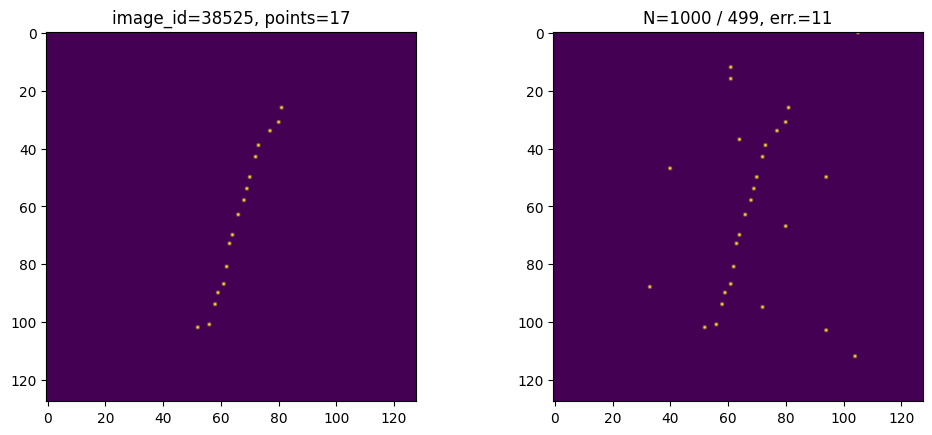

In [55]:
image_id = RNG.choice(df_train_images.index)
image = next(df_train_images.loc[[image_id]].itertuples())
si_ind_dict = pickle.loads(image.inner_si_ind_dict)
sequences = pickle.loads(image.inner_sequences)
seq = get_sequence(sequences)
seq_xy = get_xy_sequence(seq, si_ind_dict)
ii = np.all(((seq_xy >= 0) & (seq_xy < config.sample_size)), axis=1) 
seq_xy = seq_xy[ii]
ind_seq = (seq_xy @ np.array([1, config.sample_size])).astype(int)
seq_bv_true = np.zeros((config.sample_size, config.sample_size)).ravel()
seq_bv_true[ind_seq] = 1

seq_hdv = hdc.bundle(PIXEL_HDVS[ind_seq])
seq_hdv_binary = hdc.to_binary(seq_hdv)
seq_hdv_bipolar = hdc.to_bipolar(seq_hdv_binary)
seq_hdv_bipolar_norm = hdc.normalize(seq_hdv_bipolar)
pixel_hdv_inds = np.argwhere((PIXEL_HDVS_NORM @ seq_hdv_bipolar_norm) > hdc.cos_sim_threshold).ravel()
seq_bv = np.zeros((config.sample_size, config.sample_size)).ravel()
seq_bv[pixel_hdv_inds] = 1

error_level = np.count_nonzero(seq_bv != seq_bv_true)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.set_title(f'image_id={image_id}, points={len(ind_seq)}')
ax1.imshow(seq_bv_true.reshape(config.sample_size, -1));
ax2.set_title(f'err.={error_level}')
ax2.set_title(f'N={seq_hdv.shape[0]} / {seq_hdv_binary.sum():.0f}, err.={error_level}')
ax2.imshow(seq_bv.reshape(config.sample_size, -1));

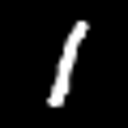

In [56]:
get_raw_image(image_id)

## .lab sbv

In [57]:
# # image_id = RNG.choice(df_train_images.index)
# # image_id = 44917 # 60 points
# image = next(df_train_images.loc[[image_id]].itertuples())
# si_ind_dict = pickle.loads(image.inner_si_ind_dict)
# sequences = pickle.loads(image.inner_sequences)
# seq = get_sequence(sequences)
# seq_xy = get_xy_sequence(seq, si_ind_dict)
# ii = np.all(((seq_xy >= 0) & (seq_xy < config.sample_size)), axis=1) 
# seq_xy = seq_xy[ii]
# ind_seq = (seq_xy @ np.array([1, config.sample_size])).astype(int)
# seq_bv_true = np.zeros((config.sample_size, config.sample_size)).ravel()
# seq_bv_true[ind_seq] = 1

# # seq_sbv = np.where(np.sum(PIXELS[ind_seq], axis=0) > 0, 1, 0) # aka Bloom filter
# seq_sbv = calc_seq_sbv(seq_xy)
# # pixel_sbv_inds = np.argwhere((PIXELS @ seq_sbv) >= SBV_NON_ZERO_INDS).ravel()
# # seq_bv = np.zeros((config.sample_size, config.sample_size)).ravel()
# # seq_bv[pixel_sbv_inds] = 1
# seq_bv = seq_sbv_to_bv(seq_sbv)

# error_level = np.count_nonzero(seq_bv != seq_bv_true)

# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_figwidth(12)
# ax1.set_title(f'image_id={image_id}, points={len(ind_seq)}')
# ax1.imshow(seq_bv_true.reshape(config.sample_size, -1))
# ax2.set_title(f'sbv={seq_sbv.shape[0]} / {seq_sbv.sum()}, non_zero_inds={HP_SIGNAL_VEC_NON_ZERO_BITS}, err.={error_level}')
# ax2.imshow(seq_bv.reshape(config.sample_size, -1));

# Train

## Parameters

In [58]:
LOG.is_enabled = True

In [59]:
HP_CLUSTER_ONES_COUNT_THRES = 6
HP_CLUSTER_CREATION_ONES_COUNT_THRES = 7
HP_CLUSTER_BINARIZATION_SCHEDULE_SIZE = 2
HP_CLUSTER_LEARN_BINARIZATION_SCHEDULE = ensure_len(np.array([5, 10], dtype='i'), HP_CLUSTER_BINARIZATION_SCHEDULE_SIZE)
HP_CLUSTER_RELEARN_BINARIZATION_SCHEDULE = ensure_len(np.array([5, 0], dtype='i'), HP_CLUSTER_BINARIZATION_SCHEDULE_SIZE)
HP_CLUSTER_BINARIZE_THRES = 0.75
HP_CLUSTER_PROD_WORK_SIGNALS_PROCESSED_THRES = 10
HP_CLUSTER_PROD_WORK_ACCURACY_THRES = 0.9
HP_CLUSTER_PROD_ETERNAL_SIGNALS_PROCESSED_THRES = 100
HP_CLUSTER_PROD_ETERNAL_ACCURACY_THRES = 0.98
        
HP_LEARN_CLUSTERS_COUNT_SOFT_LIMIT = 300_000
HP_PROD_CANDIDATE_CLUSTERS_COUNT_SOFT_LIMIT = 100_000
HP_PROD_WORK_CLUSTERS_COUNT_SOFT_LIMIT = 100_000

HP_EPOCHS_COUNT = 1
HP_OUTPUT_BITS_PER_BATCH = 250
HP_NEW_SIGNALS_COUNT_PER_CYCLE = min(100, len(df_train_images))
# HP_PERSIST_PROD_CLUSTERS_INTERVAL = 100
HP_PERSIST_PROD_CLUSTERS_INTERVAL = 999_999
HP_RESET_LEARN_CLUSTERS_INTERVAL = 100
# HP_CYCLES_COUNT = math.ceil(ACTIVE_PIXEL_FEATURES_COUNT / HP_RESET_LEARN_CLUSTERS_INTERVAL) * HP_RESET_LEARN_CLUSTERS_INTERVAL
HP_CYCLES_COUNT = 1000

## Sidecars

In [60]:
clusters_sidecar_patch_field_names = ['state', 'key', 'output_bit', 'input_bits', 'ones_count', 'last_activity_cycle', 'accuracy_calc', 'verify_signal_ids']
ClustersSidecarPatch = namedtuple('ClustersSidecarPatch', clusters_sidecar_patch_field_names, defaults = [None] * len(clusters_sidecar_patch_field_names))
NON_EXISTING_OUTPUT_BIT = 999_999_999

class LearnClustersSidecar(HdvArrayObserver):
    def __init__(self):
        # CPU side arrays
        self.is_present_boolmap = np.array([], dtype=bool)
        self.states = np.array([], dtype='object')
        self.states_counter = Counter()
        self.keys = np.array([], dtype='object')
        self.output_bits = np.array([], dtype='i')
        self.input_bits_list = np.array([], dtype='object')
        self.ones_counts = np.array([], dtype='i')
        self.last_activity_cycles = np.array([], dtype='i')
        self.is_dead_boolmap = np.array([], dtype=bool)
        
        # HOT GPU related arrays. Change in CUDA kernels only to avoid manyfold slowdowns!
        self.ws = xp.array([], dtype='f') # weights of clusters
        self.output_bits_gpu = xp.array([], dtype='i')
        self.nus = xp.array([], dtype='f')
        self.binarization_schedules = xp.array([], dtype='i')
        self.binarization_countdowns = xp.array([], dtype='i')

    def size_changed(self, new_size):
        # ndarray.resize if faster than np.resize and fills new space with zeros unlike np.resize. Unfortunately cupy doesn't have ndarray.resize
        self.is_present_boolmap.resize(new_size, refcheck=False)
        self.states.resize(new_size, refcheck=False)
        self.keys.resize(new_size, refcheck=False)
        self.output_bits.resize(new_size, refcheck=False)
        self.input_bits_list.resize(new_size, refcheck=False)
        self.ones_counts.resize(new_size, refcheck=False)
        self.last_activity_cycles.resize(new_size, refcheck=False)
        self.is_dead_boolmap.resize(new_size, refcheck=False)
        
        self.ws = xp.resize(self.ws, (new_size, HP_MAX_CLUSTER_SIZE))
        self.output_bits_gpu = xp.resize(self.output_bits_gpu, new_size)
        self.nus = xp.resize(self.nus, new_size)
        self.binarization_schedules = xp.resize(self.binarization_schedules, (new_size, HP_CLUSTER_BINARIZATION_SCHEDULE_SIZE))
        self.binarization_countdowns = xp.resize(self.binarization_countdowns, new_size)

    # patch is expected to be of type ClustersSidecarPatch
    def update(self, cluster_ind, patch):
        self.is_present_boolmap[cluster_ind] = True
        
        if not patch.state is None:
            old_state = self.states[cluster_ind]
            if old_state: self.states_counter[old_state] -= 1
            self.states[cluster_ind] = patch.state
            self.states_counter[patch.state] += 1
            self.is_dead_boolmap[cluster_ind] = patch.state == ClusterState.DEAD

        def process_patch_field(self_field, patch_field):
            if not patch_field is None:
                self_field[cluster_ind] = patch_field

        process_patch_field(self.keys, patch.key)
        process_patch_field(self.output_bits, patch.output_bit)
        process_patch_field(self.input_bits_list, patch.input_bits)
        process_patch_field(self.ones_counts, patch.ones_count)
        process_patch_field(self.last_activity_cycles, patch.last_activity_cycle)
    
    def remove(self, cluster_ind):
        self.is_present_boolmap[cluster_ind] = False
        old_state = self.states[cluster_ind]

        if old_state:
            self.states_counter[old_state] -= 1
            assert self.states_counter[old_state] >= 0
            
        self.states[cluster_ind] = 0
        self.keys[cluster_ind] = ()
        self.output_bits[cluster_ind] = NON_EXISTING_OUTPUT_BIT
        self.input_bits_list[cluster_ind] = ()
        self.ones_counts[cluster_ind] = 0
        self.last_activity_cycles[cluster_ind] = 0
        self.is_dead_boolmap[cluster_ind] = False
        
        # Don't update arrays on GPU side. Manyfold slowdown!!!
        # self.masks, self.output_bits, self.nus, ...

class ClustersSidecar(HdvArrayObserver):
    def __init__(self):
        self.is_present_boolmap = np.array([], dtype=bool)
        self.states = np.array([], dtype='object')
        self.states_counter = Counter()
        self.keys = np.array([], dtype='object')
        self.output_bits = np.array([], dtype='i') 
        self.input_bits_list = np.array([], dtype='object')
        self.ones_counts = np.array([], dtype='i') 
        self.last_activity_cycles = np.array([], dtype='i')
        self.verify_signal_ids_list = np.array([], dtype='object')
        self.accuracy_calcs = np.array([], dtype='object')
        self.is_dead_boolmap = np.array([], dtype=bool)
        self.is_verifiable_boolmap = np.array([], dtype=bool)
        self.is_promotable_to_prod_work_boolmap = np.array([], dtype=bool)
        self.is_prod_candidate_boolmap = np.array([], dtype=bool)
        self.is_prod_work_boolmap = np.array([], dtype=bool)

    def size_changed(self, new_size):
        self.is_present_boolmap.resize(new_size, refcheck=False)
        self.states.resize(new_size, refcheck=False)
        self.keys.resize(new_size, refcheck=False)
        self.input_bits_list.resize(new_size, refcheck=False)
        self.last_activity_cycles.resize(new_size, refcheck=False)
        self.verify_signal_ids_list.resize(new_size, refcheck=False)
        self.accuracy_calcs.resize(new_size, refcheck=False)
        self.output_bits.resize(new_size, refcheck=False)
        self.ones_counts.resize(new_size, refcheck=False)
        self.is_dead_boolmap.resize(new_size, refcheck=False)
        self.is_verifiable_boolmap.resize(new_size, refcheck=False)
        self.is_promotable_to_prod_work_boolmap.resize(new_size, refcheck=False)
        self.is_prod_candidate_boolmap.resize(new_size, refcheck=False)
        self.is_prod_work_boolmap.resize(new_size, refcheck=False)

    # patch is expected to be of type ClustersSidecarPatch
    def update(self, cluster_ind, patch):
        self.is_present_boolmap[cluster_ind] = True
        
        if not patch.state is None:
            old_state = self.states[cluster_ind]
            if old_state: self.states_counter[old_state] -= 1
            self.states[cluster_ind] = patch.state
            self.states_counter[patch.state] += 1
            self.is_dead_boolmap[cluster_ind] = patch.state == ClusterState.DEAD
            self.is_verifiable_boolmap[cluster_ind] = patch.state in [ClusterState.PROD_CANDIDATE, ClusterState.PROD_WORK]
            self.is_prod_candidate_boolmap[cluster_ind] = patch.state == ClusterState.PROD_CANDIDATE
            self.is_prod_work_boolmap[cluster_ind] = patch.state == ClusterState.PROD_WORK

        def process_patch_field(self_field, patch_field):
            if not patch_field is None:
                self_field[cluster_ind] = patch_field

        process_patch_field(self.keys, patch.key)
        process_patch_field(self.output_bits, patch.output_bit)
        process_patch_field(self.input_bits_list, patch.input_bits)
        process_patch_field(self.ones_counts, patch.ones_count)
        process_patch_field(self.last_activity_cycles, patch.last_activity_cycle)
        process_patch_field(self.verify_signal_ids_list, patch.verify_signal_ids)
        process_patch_field(self.accuracy_calcs, patch.accuracy_calc)
            
        is_promotable = self.states[cluster_ind] == ClusterState.PROD_CANDIDATE and len(self.verify_signal_ids_list[cluster_ind]) >= HP_CLUSTER_PROD_WORK_SIGNALS_PROCESSED_THRES
        self.is_promotable_to_prod_work_boolmap[cluster_ind] = is_promotable

    def remove(self, cluster_ind):
        self.is_present_boolmap[cluster_ind] = False
        
        old_state = self.states[cluster_ind]

        if old_state:
            self.states_counter[old_state] -= 1
            assert self.states_counter[old_state] >= 0
            
        self.states[cluster_ind] = 0
        self.keys[cluster_ind] = ()
        self.output_bits[cluster_ind] = NON_EXISTING_OUTPUT_BIT
        self.input_bits_list[cluster_ind] = ()
        self.ones_counts[cluster_ind] = 0
        self.last_activity_cycles[cluster_ind] = 0
        self.verify_signal_ids_list[cluster_ind] = []
        self.is_dead_boolmap[cluster_ind] = False
        self.is_verifiable_boolmap[cluster_ind] = False
        self.is_promotable_to_prod_work_boolmap[cluster_ind] = False
        self.is_prod_candidate_boolmap[cluster_ind] = False
        self.is_prod_work_boolmap[cluster_ind] = False

## CUDA Kernels

### cuda_get_source_data_for_new_clusters

In [61]:
cuda_get_source_data_for_new_clusters = cp.RawKernel(r'''
#include <assert.h>

extern "C" __global__
void get_source_data_for_new_clusters(
    // INPUT
    const int theHpVecLen,
    const int theHpMaxClusterSize,
    const int theHpCreationOnesCountThres,
    const int * const theSignalInput, // vector[theHpVecLen]
    const int * const theSignalOutput, // vector[theHpVecLen]
    const int thePointsCount,
    const int * const thePoints,          // matrix[thePointsCount][theHpMaxClusterSize]
    const int * const thePointOutputBits, // vector[thePointsCount] 
    // OUTPUT DATA
    int * const theNzbCounts, // vector[thePointsCount]
    int * const theNzbs // matrix[thePointsCount][theHpMaxClusterSize]
) { 
    const int pointInd = blockDim.x * blockIdx.x + threadIdx.x;

    if(pointInd >= thePointsCount)
        return;

    int nzbCount = 0;
    const int outputBit = thePointOutputBits[pointInd];
    assert(outputBit >= 0 && outputBit < theHpVecLen);

    if(theSignalOutput[outputBit]) {
        const int * const point = &thePoints[pointInd * theHpMaxClusterSize];
        int * const nzb = &theNzbs[pointInd * theHpMaxClusterSize];
        
        for(int i = 0; i < theHpMaxClusterSize; i++) {
            const int bitNo = point[i];
            assert(bitNo >=0 && bitNo < theHpVecLen);
    
            /*if(pointInd == 0) {
                printf("kms@ pointInd=%d, theHpMaxClusterSize=%d, i=%d, bitNo=%d, theSignalInput[bitNo]=%d, nzbCount=%d\n", 
                    pointInd, theHpMaxClusterSize, i, bitNo, theSignalInput[bitNo], nzbCount);
            }*/
            
            if(theSignalInput[bitNo] > 0) {
                assert(nzbCount < theHpMaxClusterSize);
                nzb[nzbCount] = bitNo;
                nzbCount++;
            }
        }
    }

    theNzbCounts[pointInd] = nzbCount >= theHpCreationOnesCountThres ? nzbCount : 0;
}
''', 'get_source_data_for_new_clusters', backend='nvcc')
cuda_get_source_data_for_new_clusters.compile()

### cuda_init_new_clusters

In [62]:
cuda_init_learn_clusters = cp.RawKernel(r'''
#include <assert.h>

extern "C" __global__
void init_learn_clusters(
    // INPUT
    const int theHpVecLen,
    const int theHpMaxClusterSize,
    const int theHpBinarizationScheduleSize,
    const int * const theHpBinarizationScheduleTemplate, // vector[theHpBinarizationScheduleSize]
    const int theClustersCount,
    const int * const theClusterInds, // vector[theClustersCount]
    const int * const theClusterOutputBitsLocal, // vector[theClustersCount]
    const int * const theClusterNzbCounts, // vector[theClustersCount], may be null in which case we assume that theClusters is already initialized
    const int * const theClusterNzbs, // matrix[theClustersCount][theHpMaxClusterSize], may be null in which case we assume that theClusters is already initialized
    // OUTPUT
    int * const theClusters, // matrix[**realClustersCount**][theHpMaxClusterSize] 
    float * const theClusterWs, // matrix[**realClustersCount**][theHpMaxClusterSize]
    int * const theClusterOutputBits, // vector[**realClustersCount**]
    float * const theClusterNus, // vector[**realClustersCount**]
    int * const theClusterBinarizationSchedules, // matrix[**realClustersCount**][theHpBinarizationScheduleSize]
    int * const theClusterBinarizationCountdowns // vector[**realClustersCount**]
) { 
    const int localClusterInd = blockDim.x * blockIdx.x + threadIdx.x;

    if(localClusterInd >= theClustersCount)
        return;

    const int clusterInd = theClusterInds[localClusterInd];
    const auto clustersPtrOffset = clusterInd * theHpMaxClusterSize;
    int * const cluster = theClusters + clustersPtrOffset;
    float * const weights = theClusterWs + clustersPtrOffset;
    int nzbCount = 0;

   if(theClusterNzbCounts && theClusterNzbs) {
        // Init cluster and weights from NZB data
        nzbCount = theClusterNzbCounts[localClusterInd]; // how many bits are ON, aka onesCount or size
        const int * const nzb = &theClusterNzbs[localClusterInd * theHpMaxClusterSize];
        memcpy(cluster, nzb, sizeof(nzb[0]) * theHpMaxClusterSize); // e.g. [10, 25, 312, 567, -1, -1, -1, ...]
        
        for(int i = 0; i < theHpMaxClusterSize; i++) {
            weights[i] = i < nzbCount ? 1.0f : 0.0f;

            if(weights[i])
                assert(cluster[i] >= 0); 
            else {
                assert(cluster[i] == -1);
                assert(i == (theHpMaxClusterSize - 1) || cluster[i+1] == -1);
            }
        }
    }
    else {
        // Cluster is already initialized, so use its data to initialize weights and compute nzbCount
        for(int i = 0; i < theHpMaxClusterSize; i++) {
            const int w = cluster[i] >= 0 ? 1 : 0;

            if(!w && i < (theHpMaxClusterSize - 1)) {
                // assert there is no gaps, e.g. [3, 17, -1, 22, -1, ....]
                assert(cluster[i+1] == -1);
            }
            
            weights[i] = float(w);
            nzbCount += w;
        }
    }

    theClusterOutputBits[clusterInd] = theClusterOutputBitsLocal[localClusterInd];
    theClusterNus[clusterInd] = 1.0f / nzbCount;
    memcpy(
        theClusterBinarizationSchedules + clusterInd * theHpBinarizationScheduleSize, 
        theHpBinarizationScheduleTemplate, 
        theHpBinarizationScheduleSize * sizeof(theHpBinarizationScheduleTemplate[0]));
    theClusterBinarizationCountdowns[clusterInd] = theHpBinarizationScheduleTemplate[0];
}
''', 'init_learn_clusters', backend='nvcc')
cuda_init_learn_clusters.compile()

### cuda_learn_clusters

In [63]:
cuda_learn_clusters = cp.RawKernel(r'''
#include <assert.h>

extern "C" __device__
void binarize_cluster(
    // INPUT
    const int theHpVecLen,
    const int theHpMaxClusterSize,
    const float theHpBinarizeThres,
    const int theHpBinarizationScheduleSize,
    // INPUT-OUTPUT 
    int * theCluster,    // vector[theHpMaxClusterSize]
    float * const theWeights, // vector[theHpMaxClusterSize]
    float * const theNu, // pointer to scalar
    int * const theBinarizationSchedule, // vector[theHpBinarizationScheduleSize]
    int * const theBinarizationCountdown, // pointer to scalar
    // OUTPUT
    int * const theOnesCount // pointer to scalar
) {
    *theOnesCount = 0;
    
    for(int i = 0; i < theHpMaxClusterSize; i++) {
        const int bitNo = theCluster[i];

        if(bitNo < 0)
            break;

        if(theWeights[i] > theHpBinarizeThres) {
            assert(*theOnesCount >= 0 && *theOnesCount < theHpMaxClusterSize);
            theCluster[*theOnesCount] = bitNo;
            theWeights[*theOnesCount] = 1.0f;
            *theOnesCount += 1;
        }
    }

    // healthcheck and tail make up (fill tail with -1 and 0.0f)
    assert(*theOnesCount > 0);
    int lastBitNo = -1;
    
    for(int i = 0; i < theHpMaxClusterSize; i++) {
        if(i < *theOnesCount) {
            assert(theCluster[i] >= 0 && theCluster[i] < theHpVecLen);
            assert(theCluster[i] > lastBitNo); // monotonicity check
            assert(theWeights[i] == 1.0f);
            lastBitNo = theCluster[i];
        }
        else {
            theCluster[i] = -1;
            theWeights[i] = 0.0f;
        }
    }

    *theNu = 1.0f / *theOnesCount;
    
    // Can't use memmove within __device__ function =(, so do array rolling by hand
    for(int i = 0; i < theHpBinarizationScheduleSize - 1; i++)
        theBinarizationSchedule[i] = theBinarizationSchedule[i + 1];
        
    theBinarizationSchedule[theHpBinarizationScheduleSize - 1] = 0;
    *theBinarizationCountdown = theBinarizationSchedule[0];
}

extern "C" __global__
void learn_clusters(
    // INPUT
    const int theHpVecLen,
    const int theHpMaxClusterSize,
    const float theHpBinarizeThres,
    const int theHpClusterOnesCountThres,
    const int theHpBinarizationScheduleSize,
    const int theSignalsCount,
    const int * const theSignalsInput,  // matrix[theSignalsCount][theHpVecLen]
    const int * const theSignalsOutput,  // matrix[theSignalsCount][theHpVecLen]
    const int theClustersCount,
    const int * const theClusterInds, // vector[theClustersCount], mapping from local clusterInd to real clusterInd
    const int * const theClusterOutputBits, // vector[**realClustersCount**]
    // INPUT-OUTPUT (results are retained over calls, i.e. non-idempotent)
    int * theClusters,          // matrix[**realClustersCount**][theHpMaxClusterSize]
    float * const theClusterWs, // matrix[**realClustersCount**][theHpMaxClusterSize]
    float * const theClusterNus, // vector[**realClustersCount**]
    int * const theClusterBinarizationSchedules, // matrix[**realClustersCount**][theHpBinarizationScheduleSize]
    int * const theClusterBinarizationCountdowns, // vector[**realClustersCount**]
    // OUTPUT
    int * const theClusterOnesCounts, // vector[**realClustersCount**]
    bool * const theClusterIsChangedBoolmap, // vector[**realClustersCount**]
    bool * const theClusterIsBinarizedBoolmap, // vector[**realClustersCount**]
    bool * const theClusterIsReadyBoolmap // vector[**realClustersCount**]
) { 
    const int localClusterInd = blockDim.x * blockIdx.x + threadIdx.x;

    if(localClusterInd >= theClustersCount)
        return;

    const int clusterInd = theClusterInds[localClusterInd];
    const int outputBit = theClusterOutputBits[clusterInd];
    const auto clustersPtrOffset = clusterInd * theHpMaxClusterSize;
    int * const cluster = theClusters + clustersPtrOffset;
    float * const weights = theClusterWs + clustersPtrOffset;
    float * const nu = &theClusterNus[clusterInd];
    int * const binarizationSchedule = theClusterBinarizationSchedules + clusterInd * theHpBinarizationScheduleSize;
    int * const binarizationCountdown = &theClusterBinarizationCountdowns[clusterInd];
    int * const onesCount = &theClusterOnesCounts[clusterInd];
    bool * const isChanged = &theClusterIsChangedBoolmap[clusterInd];
    bool * const isBinarized = &theClusterIsBinarizedBoolmap[clusterInd];
    bool * const isReady = &theClusterIsReadyBoolmap[clusterInd];

    // Healthcheck + onesCount compute
    *onesCount = 0;
    
    for(int i = 0; i < theHpMaxClusterSize; i++) {
        const int bitNo = cluster[i];
        
        if(bitNo >= 0) {
            assert(bitNo >= 0 && bitNo < theHpVecLen);
            if(weights[i] <= 0.0f) {
                printf("kms@ clusterInd=%d, i=%d, weights[i]=%f\n", clusterInd, i, weights[i]);
            }
            assert(weights[i] > 0.0f);
            *onesCount += 1;
        }
        else {
            assert(weights[i] == 0.0f);
            assert(i == (theHpMaxClusterSize - 1) || cluster[i+1] == -1);
        }
    }

    *isChanged = false;
    *isBinarized = false;
    assert(*binarizationCountdown >= 0);
    *isReady = *binarizationCountdown == 0 && binarizationSchedule[0] == 0;

    if(*isReady)
        return;

    for(int signalInd = 0; signalInd < theSignalsCount && !*isBinarized; signalInd++) {
        if(*binarizationCountdown <= 0) {
            binarize_cluster(
                theHpVecLen, theHpMaxClusterSize, theHpBinarizeThres, theHpBinarizationScheduleSize,
                cluster, weights, nu, binarizationSchedule, binarizationCountdown, onesCount
            );
            *isChanged = false;
            *isBinarized = true;

            assert(*binarizationCountdown >= 0);
            break;
        }
    
        const auto signalsPtrOffset = signalInd * theHpVecLen;
        const int * const signalInput = theSignalsInput + signalsPtrOffset;
        const int * const signalOutput = theSignalsOutput + signalsPtrOffset;
    
        if(!signalOutput[outputBit])
            continue;
    
        float activationStrength = 0.0f;
        int bitsTouched = 0;
        
        for(int i = 0; i < *onesCount; i++) {
            const int bitNo = cluster[i];
            assert(bitNo >= 0 && bitNo < theHpVecLen);
            const float inputBitValue = signalInput[bitNo]; 
            activationStrength += inputBitValue ? weights[i] : 0;
            bitsTouched += inputBitValue ? 1 : 0;
        }
    
        if(bitsTouched < theHpClusterOnesCountThres)
            continue;
    
        const float k = (*nu) * activationStrength;
        float maxWeight = 0.0f;
        
        for(int i = 0; i < *onesCount; i++) {
            const int bitNo = cluster[i];
            const float updatedWeight = weights[i] + k * signalInput[bitNo];
            weights[i] = updatedWeight;
            maxWeight = fmax(maxWeight, updatedWeight);
        }
    
        for(int i = 0; i < *onesCount; i++) {
            weights[i] /= maxWeight;
        }
    
        *binarizationCountdown -= 1;
        assert(*binarizationCountdown >= 0);
        *isChanged = true;
    }

    if(*isChanged) assert(!*isBinarized);
    if(*isBinarized) assert(!*isChanged);
}
''', 'learn_clusters', backend='nvcc')
cuda_learn_clusters.compile()

### cuda_migrate_clusters

In [64]:
cuda_migrate_clusters = cp.RawKernel(r'''
const int CLUSTER_IND_MAPPING_SIZE = 2;

extern "C" __global__
void migrate_clusters(
    // INPUT
    const int theHpMaxClusterSize,
    const int theClusterIndMappingsCount,
    const int * const theClusterIndMappings, // matrix [theClustersCount][CLUSTER_IND_MAPPING_SIZE] - each row is a pair (mapping) fromClusterInd -> toClusterInd
    const int * const theSourceClusters,   // matrix[**realClustersCount**][theHpMaxClusterSize]
    // OUTPUT
    int * const theTargetClusters      // matrix[**realClustersCount**][theHpMaxClusterSize]
) { 
    const int mappingInd = blockDim.x * blockIdx.x + threadIdx.x;

    if(mappingInd >= theClusterIndMappingsCount)
        return;

    const int * const mapping = &theClusterIndMappings[mappingInd * CLUSTER_IND_MAPPING_SIZE];
    const int sourceClusterInd = mapping[0];
    const int targetClusterInd = mapping[1];
    const int * const sourceCluster = &theSourceClusters[sourceClusterInd * theHpMaxClusterSize];
    int * const targetCluster = &theTargetClusters[targetClusterInd * theHpMaxClusterSize];

    memcpy(targetCluster, sourceCluster, sizeof(sourceCluster[0]) * theHpMaxClusterSize);
}
''', 'migrate_clusters')
cuda_migrate_clusters.compile()

### cuda_apply_clusters

In [65]:
cuda_apply_clusters = cp.RawKernel(r'''
#include <assert.h>

extern "C" __global__
void apply_clusters(
    // INPUT
    const int theHpVecLen,
    const int theHpMaxClusterSize,
    const int theSignalsCount,
    const int * const theSignalsInput,  // matrix[theSignalsCount][theHpVecLen]
    const int * const theSignalsOutput,  // matrix[theSignalsCount][theHpVecLen]
    const int theClustersCount,
    const int * const theClusterInds,       // vector[theClustersCount], mapping from local clusterInd to real clusterInd
    const int * const theClusters,          // matrix[**realClustersCount**][theHpMaxClusterSize]
    const int * const theClusterOutputBits, // vector[**realClustersCount**]
    // OUTPUT
    int * const theResults // matrix[theClustersCount][theSignalsCount]; 0 - cluster didnt react, -1 - wrong reaction (FP), +1 - correct reaction (TP)
) { 
    const int localClusterInd = blockDim.x * blockIdx.x + threadIdx.x;

    if(localClusterInd >= theClustersCount)
        return;

    const int clusterInd = theClusterInds[localClusterInd];
    const int * const cluster = &theClusters[clusterInd * theHpMaxClusterSize];
    const int outputBit = theClusterOutputBits[clusterInd];
    int * const resultsRow = &theResults[localClusterInd * theSignalsCount];
    int onesCount = 0;

    for(int i = 0; i < theHpMaxClusterSize; i++) {
        const int bitNo = cluster[i];
        assert((bitNo >= 0 && bitNo < theHpVecLen) || (bitNo == -1));
        
        if(bitNo >= 0) onesCount++;
        else break;
    }

    assert(onesCount > 0 && onesCount <= theHpMaxClusterSize);

    for(int signalInd = 0; signalInd < theSignalsCount; signalInd++) {
        const auto signalsPtrOffset = signalInd * theHpVecLen;
        const int * const signalInput = theSignalsInput + signalsPtrOffset;
        const int * const signalOutput = theSignalsOutput + signalsPtrOffset;
        int bitsTouched = 0;
        
        for(int i = 0; i < onesCount; i++) {
            const int bitNo = cluster[i];
            bitsTouched += signalInput[bitNo] ? 1 : 0;
        }

        if(bitsTouched < onesCount) {
            resultsRow[signalInd] = 0;
        }
        else {
            resultsRow[signalInd] = signalOutput[outputBit] ? +1 : -1;
        }
    }
}
''', 'apply_clusters', backend='nvcc')
cuda_apply_clusters.compile()

### cuda_check_clusters_integrity

In [66]:
cuda_check_clusters_integrity = cp.RawKernel(r'''
#include <assert.h>

extern "C" __global__
void check_clusters_integrity(
    // INPUT
    const int theHpVecLen,
    const int theHpMaxClusterSize,
    const int theClustersCount,
    const int * const theClusterInds, // vector[theClustersCount], mapping from local clusterInd to real clusterInd
    const int * const theClusters,          // matrix[**realClustersCount**][theHpMaxClusterSize]
    const float * const theClusterWs, // matrix[**realClustersCount**][theHpMaxClusterSize]
    // OUTPUT
    int * const theClusterOnesCounts, // vector[**realClustersCount**]
    bool * const theClusterIsOkBoolmap // vector[**realClustersCount**]
) { 
    const int localClusterInd = blockDim.x * blockIdx.x + threadIdx.x;

    if(localClusterInd >= theClustersCount)
        return;

    const int clusterInd = theClusterInds[localClusterInd];
    const auto clustersPtrOffset = clusterInd * theHpMaxClusterSize;
    const int * const cluster = theClusters + clustersPtrOffset;
    const float * const weights = theClusterWs + clustersPtrOffset;
    int * const onesCount = &theClusterOnesCounts[clusterInd];
    bool * const isOk = &theClusterIsOkBoolmap[clusterInd];
    *isOk = true;

    // Healthcheck + onesCount compute
    *onesCount = 0;
    
    for(int i = 0; i < theHpMaxClusterSize; i++) {
        const int bitNo = cluster[i];
        
        if(bitNo >= 0) {
            if(bitNo < 0 || bitNo >= theHpVecLen) {
                printf("kms@ 1) clusterInd=%d, i=%d, cluster[i]=%d\n", clusterInd, i, cluster[i]);
                *isOk = false;
                return;
            }
            
            if(weights[i] <= 0.0f) {
                printf("kms@ 2) clusterInd=%d, i=%d, weights[i]=%f\n", clusterInd, i, weights[i]);
                *isOk = false;
                return;
            }
            
            *onesCount += 1;
        }
        else {
            if(weights[i] != 0.0f) {
                printf("kms@ 3) clusterInd=%d, i=%d, weights[i]=%f\n", clusterInd, i, weights[i]);
                *isOk = false;
                return;
            }

            if(i != (theHpMaxClusterSize - 1) && cluster[i+1] != -1) {
                printf("kms@ 4) clusterInd=%d, i=%d, cluster[i]=%d, cluster[i+1]=%d\n", clusterInd, i, cluster[i], cluster[i+1]);
                *isOk = false;
                return;
            }
        }
    }
}
''', 'check_clusters_integrity', backend='nvcc')
cuda_check_clusters_integrity.compile()

### cuda_convert_clusters_to_sbv_format

In [67]:
cuda_convert_clusters_to_sbv_format = cp.RawKernel(r'''
extern "C" __global__
void convert_clusters_to_sbv_format(
    // INPUT
    const int theHpVecLen,
    const int theHpMaxClusterSize,
    const int theClustersCount,
    const int * const theClusters,    // matrix[theClustersCount][theHpMaxClusterSize]
    // OUTPUT
    int * const theSbvClusters        // matrix[theClustersCount][theHpVecLen]
) { 
    const int clusterInd = blockDim.x * blockIdx.x + threadIdx.x;

    if(clusterInd >= theClustersCount)
        return;

    // printf("kms@ theHpVecLen=%d, theHpMaxClusterSize=%d, theClustersCount=%d, clusterInd=%d\n", theHpVecLen, theHpMaxClusterSize, theClustersCount, clusterInd);

    const int * const cluster = &theClusters[clusterInd * theHpMaxClusterSize];
    int * const sbvCluster = &theSbvClusters[clusterInd * theHpVecLen];
    memset(sbvCluster, 0, sizeof(sbvCluster[0]) * theHpVecLen);

    for(int i = 0; i < theHpMaxClusterSize; i++) {
        const int bitNo = cluster[i];
        assert(bitNo == -1 || (bitNo >= 0 && bitNo < theHpVecLen));

        if(bitNo == -1)
            break;
            
        sbvCluster[bitNo] = 1;
    }
}
''', 'convert_clusters_to_sbv_format')
cuda_convert_clusters_to_sbv_format.compile()

## persist_prod_clusters

In [68]:
def persist_prod_clusters():
    persisted_count = 0
    output_bit_to_cluster_inds = defaultdict(list)
    cluster_inds = np.flatnonzero(CLUSTERS_SIDECAR.is_present_boolmap[:CLUSTERS.active_len])
    
    for cluster_ind in cluster_inds:
        output_bit = CLUSTERS_SIDECAR.output_bits[cluster_ind]
        output_bit_to_cluster_inds[output_bit].append(cluster_ind)
    
    for output_bit, cluster_inds in output_bit_to_cluster_inds.items():
        # Leave only super clusters, i.e. clusters which are not subsets of any other clusters
        cluster_inds = np.array(cluster_inds)
        clusters_nzb = CLUSTERS.array[cluster_inds] # nzb format, i.e. [3, 67, 298, -1, -1, ...]
        clusters = xp.zeros((clusters_nzb.shape[0], HP_SIGNAL_VEC_LEN), dtype='i')

        cuda_block_size = 256
        cuda_blocks_count = math.ceil(clusters_nzb.shape[0] / cuda_block_size)
        cuda_convert_clusters_to_sbv_format(
            (cuda_blocks_count, ), (cuda_block_size,),
            (
                # INPUT
                cp.int32(HP_SIGNAL_VEC_LEN),
                cp.int32(HP_MAX_CLUSTER_SIZE),
                cp.int32(clusters_nzb.shape[0]),
                ensure_dtype(clusters_nzb, cp.int32),
                # OUTPUT
                ensure_dtype(clusters, cp.int32),
             )
        )
        
        cluster_ones_counts = clusters.sum(axis=1)
        crossings = (clusters @ clusters.T)
        crossings[xp.diag_indices_from(crossings)] = 0
        super_clusters_boolmap = ~xp.any((crossings.T >= cluster_ones_counts).T, axis=1)
    
        super_clusters = xp_array_from_gpu(clusters[super_clusters_boolmap])
        super_cluster_inds = cluster_inds[xp_array_from_gpu(super_clusters_boolmap)]
        assert len(super_clusters) == len(super_cluster_inds)
        
        metas = []
        
        for super_cluster_ind in super_cluster_inds:
            meta = ClusterMeta(super_cluster_ind)
            meta.cluster_key = CLUSTERS_SIDECAR.keys[super_cluster_ind]
            assert output_bit == CLUSTERS_SIDECAR.output_bits[super_cluster_ind]
            meta.output_bit = output_bit
            meta.input_bits = CLUSTERS_SIDECAR.input_bits_list[super_cluster_ind]
            meta.ones_count = CLUSTERS_SIDECAR.ones_counts[super_cluster_ind]
            assert meta.ones_count == len(meta.input_bits)
            meta.last_activity_cycle = 0
            meta.accuracy_calc = CLUSTERS_SIDECAR.accuracy_calcs[super_cluster_ind]
            meta.verify_signal_ids = CLUSTERS_SIDECAR.verify_signal_ids_list[super_cluster_ind]
            metas.append(meta)
            
        nzb_list = list(map(sbv_to_nzb, super_clusters))
        pickled_nzb_list = pickle.dumps(nzb_list)
        pickled_metas = pickle.dumps(metas)
        # Changing autocommit to False will open a new transaction, and changing it to True will commit any pending transaction.
        # https://docs.python.org/3/library/sqlite3.html#connection-objects
        transfs_db_con.autocommit = False
        transfs_db_con.execute('DELETE FROM clusters WHERE encoding=:encoding AND transf_code=:transf_code AND output_bit=:output_bit',
                               {'encoding': HP_SIGNAL_ENCODING, 'transf_code': TRANSF_CODE, 'output_bit': output_bit})
        transfs_db_con.execute('INSERT INTO clusters (encoding, transf_code, output_bit, metas, nzb_list) VALUES (:encoding, :transf_code, :output_bit, :metas, :nzb_list)',
                               {'encoding': HP_SIGNAL_ENCODING, 'transf_code': TRANSF_CODE, 'output_bit': output_bit, 'metas': pickled_metas, 'nzb_list': pickled_nzb_list})
        transfs_db_con.autocommit = True
        persisted_count += clusters.shape[0]
        LOG(f'Persisted {clusters.shape[0]} (of {len(cluster_inds)}) super clusters for output bit {output_bit}')
    
    LOG(f'Persisted {persisted_count} clusters in total for encoding="{HP_SIGNAL_ENCODING}" and transf_code="{TRANSF_CODE}"')

## Train Loop

In [69]:
# batch_output_bits_filter = lambda s, e: True
# batch_output_bits_filter = lambda s, e: s >= 500
batch_output_bits_filter = lambda s, e: s >= 750 and s < 1000

if 'signals_generator' in globals():
    if isinstance(signals_generator, AsyncSignalsGenerator):
        signals_generator.terminate()
        del signals_generator

# signals_generator = AsyncSignalsGenerator(RealImageSignalsGenerator, TRANSF, HP_NEW_SIGNALS_COUNT_PER_CYCLE, 10)
# signals_generator = AsyncSignalsGenerator(RollingPixelFeatureSignalsGenerator, TRANSF, HP_NEW_SIGNALS_COUNT_PER_CYCLE, 1)
# signals_generator = AsyncSignalsGenerator(PooledPixelFeatureSignalsGenerator, TRANSF, HP_NEW_SIGNALS_COUNT_PER_CYCLE, 160, 200)
signals_generator = AsyncSignalsGenerator(PooledPixelFeatureSignalsGenerator, TRANSF, HP_NEW_SIGNALS_COUNT_PER_CYCLE, 100)

persist_prod_clusters_governeur = interval_governeur(HP_PERSIST_PROD_CLUSTERS_INTERVAL, persist_prod_clusters)

for epoch in tqdm(range(HP_EPOCHS_COUNT), desc='Epoch'):
    with LOG.auto_prefix('EPOCH', epoch):
        for start_output_bit in tqdm(range(0, HP_SIGNAL_VEC_LEN, HP_OUTPUT_BITS_PER_BATCH), leave=False, desc='Output bit batch'):
            end_output_bit = start_output_bit + HP_OUTPUT_BITS_PER_BATCH - 1
            end_output_bit = min(end_output_bit, HP_SIGNAL_VEC_LEN - 1)
            assert end_output_bit >= start_output_bit, (start_output_bit, end_output_bit)

            if not batch_output_bits_filter(start_output_bit, end_output_bit):
                continue
            
            with LOG.auto_prefix('OBITS', f'{start_output_bit}:{end_output_bit}'):
                CLUSTERS_SIDECAR = ClustersSidecar()
                CLUSTERS = HdvArray(HP_MAX_CLUSTER_SIZE, xp, initial_length=100_000, dtype='i', grow_policy=hdv_array_log_like_grow_policy, observer=CLUSTERS_SIDECAR)

                LEARN_CLUSTERS_SIDECAR = None
                LEARN_CLUSTERS = None

                def reset_learn_clusters():
                    global LEARN_CLUSTERS_SIDECAR, LEARN_CLUSTERS
                    LEARN_CLUSTERS_SIDECAR = LearnClustersSidecar()
                    LEARN_CLUSTERS = HdvArray(HP_MAX_CLUSTER_SIZE, xp, initial_length=100_000, dtype='i', grow_policy=hdv_array_log_like_grow_policy, observer=LEARN_CLUSTERS_SIDECAR)
                    LOG('LEARN clusters reset')

                reset_learn_clusters()
                reset_learn_clusters_governeur = interval_governeur(HP_RESET_LEARN_CLUSTERS_INTERVAL, reset_learn_clusters)
                
                ## Select points for output bits (OBITS)
                points_mask = (POINT_OUTPUT_BITS >= start_output_bit) & (POINT_OUTPUT_BITS <= end_output_bit)
                points = xp_array_to_gpu(POINTS[points_mask])
                point_output_bits = POINT_OUTPUT_BITS[points_mask]
                point_output_bits_gpu = xp_array_to_gpu(point_output_bits)
                point_inds = xp.arange(points.shape[0], dtype='i')
                LOG(f'{points.shape[0]} combinatorial points selected for output bits {start_output_bit}:{end_output_bit}, avg. points per output bit={points.shape[0] / ((end_output_bit - start_output_bit) + 1):.0f}')
                assert points.shape[0] > 0

                ## Restore prod clusters for output bits (OBITS)
                df_clusters = pd.read_sql('SELECT ROWID, output_bit, metas, nzb_list FROM clusters WHERE encoding=:encoding AND transf_code=:transf_code ' + 
                                          'AND output_bit>=:start_output_bit AND output_bit<=:end_output_bit', 
                                          params={
                                              'encoding': HP_SIGNAL_ENCODING, 
                                              'transf_code': TRANSF_CODE,
                                              'start_output_bit': start_output_bit, 
                                              'end_output_bit': end_output_bit}, 
                                          con=transfs_db_con)
                
                clusters = []
                cluster_inds = []
                
                for cluster_row in df_clusters.itertuples():
                    cluster_nzb_list_for_output_bit = pickle.loads(cluster_row.nzb_list)
                    cluster_metas_for_output_bit = pickle.loads(cluster_row.metas)
                    assert len(cluster_nzb_list_for_output_bit) == len(cluster_metas_for_output_bit)

                    for nzb, meta in zip(cluster_nzb_list_for_output_bit, cluster_metas_for_output_bit):
                        assert len(nzb) > 0
                        assert False
                        cluster = np.zeros(HP_SIGNAL_VEC_LEN, dtype='f')
                        cluster[nzb] = 1
                        clusters.append(cluster)
                        
                        cluster_ind = CLUSTERS.lease()
                        cluster_inds.append(cluster_ind)
                        patch = ClustersSidecarPatch(
                            state=meta.state,
                            key=meta.cluster_key, 
                            output_bit=meta.output_bit,
                            input_bits=meta.input_bits,
                            ones_count=meta.ones_count,
                            last_activity_cycle=meta.last_activity_cycle,
                            accuracy_calc=meta.accuracy_calc,
                            verify_signal_ids=meta.verify_signal_ids
                        )
                        CLUSTERS_SIDECAR.update(cluster_ind, patch)

                    LOG(f'Loaded {len(cluster_metas_for_output_bit)} clusters for output bit {cluster_row.output_bit} (ROWID={cluster_row.rowid})')

                if clusters:
                    assert len(clusters) == len(cluster_inds)
                    CLUSTERS.array[cluster_inds] = np.vstack(clusters)
                    assert np.count_nonzero(CLUSTERS_SIDECAR.is_present_boolmap) == CLUSTERS.len
                    
                LOG(f'Loaded {CLUSTERS.len} clusters in total for encoding="{HP_SIGNAL_ENCODING}" and transf_code="{TRANSF_CODE}"')

                unique_cluster_keys = set(CLUSTERS_SIDECAR.keys[CLUSTERS_SIDECAR.is_present_boolmap])
                assert len(unique_cluster_keys) == CLUSTERS.len
                new_clusters_creation_rate_calc = AverageFilter()

                sgr = DummySignalsGeneratorResult()
                
                def switch_signals_generator():
                    global sgr
                    sgr = DummySignalsGeneratorResult()
                    signals_generator.switch()
                    LOG('Signals generator switched')
                    
                switch_signals_generator_governeur = interval_governeur(HP_RESET_LEARN_CLUSTERS_INTERVAL, switch_signals_generator)

                stats_signals_processed_count = 0
                stats_parent_signals_count = 0
                stats_learn_clusters_created_count = 0
                
                def report_stats():
                    global stats_signals_processed_count, stats_parent_signals_count, stats_learn_clusters_created_count
                    LOG(f'STATS: total signals={stats_signals_processed_count:_}')
                    LOG(f'STATS: parent signals={stats_parent_signals_count:_}')
                    LOG(f'STATS: learn clusters created={stats_learn_clusters_created_count:_}')
                    stats_signals_processed_count = 0
                    stats_parent_signals_count = 0
                    stats_learn_clusters_created_count = 0
                
                report_stats_governeur = interval_governeur(HP_RESET_LEARN_CLUSTERS_INTERVAL, report_stats)
                
                ## Mine clusters
                for cycle in tqdm(range(HP_CYCLES_COUNT), leave=False, desc='Cycle'):
                    with LOG.auto_prefix('CYCLE', cycle):
                        LOG(f'===')
                        persist_prod_clusters_governeur()
                        switch_signals_generator_governeur()
                        reset_learn_clusters_governeur()
                        report_stats_governeur()
                        
                        ### General stats reporting
                        cluster_states = {}
                        cluster_states.update(LEARN_CLUSTERS_SIDECAR.states_counter.most_common())
                        cluster_states.update(CLUSTERS_SIDECAR.states_counter.most_common())
                        cluster_states_filter = filter(lambda kv: kv[1] != 0, cluster_states.items()) # retain only states with non-zero counts (eases inspection by eyes)
                        cluster_states = dict(map(lambda kv: (kv[0].name, kv[1]), cluster_states_filter))
                        LOG(f'Cycle {cycle} started, clusters: {cluster_states}, LEARN_CLUSTERS.array.shape={LEARN_CLUSTERS.array.shape}, CLUSTERS.array.shape={CLUSTERS.array.shape}')
                        
                        ### Prepare input and output signals for training
                        prev_cycle_sgr = sgr
                        sgr = signals_generator()
                        sgr = sgr._replace(
                            signals_input=xp_array_to_gpu(sgr.signals_input),
                            signals_output=xp_array_to_gpu(sgr.signals_output)
                        )
                        assert len(sgr.signal_ids) == sgr.signals_input.shape[0]
                        assert sgr.signals_input.shape[0] == sgr.signals_output.shape[0]
                        stats_signals_processed_count += sgr.signals_input.shape[0]
                        LOG(f'Prepared {sgr.signals_input.shape[0]} signals')
                        # assert False

                        ### Create new clusters
                        learn_clusters_count = cluster_states.get(ClusterState.LEARN.name, 0)
                        new_cluster_inds = []
                        new_cluster_attrs_list = namedtuple('NewClusterAttrsList', ['output_bits', 'nzb_counts', 'nzbs'])([], [], [])
                        signals_count_for_new_clusters = 0

                        # Create clusters from prev sgr to avoid situation when clusters are created and get immediately learned on the same data
                        for signal_input, signal_output in zip(prev_cycle_sgr.signals_input, prev_cycle_sgr.signals_output):
                            if learn_clusters_count + new_clusters_creation_rate_calc.value > HP_LEARN_CLUSTERS_COUNT_SOFT_LIMIT:
                                break
                                
                            signals_count_for_new_clusters += 1
                            nzb_counts = xp.zeros(points.shape[0], dtype='i')
                            nzbs = xp.full((points.shape[0], HP_MAX_CLUSTER_SIZE), -1, dtype='i')
                            cuda_block_size = 256
                            cuda_blocks_count = math.ceil(points.shape[0] / cuda_block_size)
                            cuda_get_source_data_for_new_clusters(
                                (cuda_blocks_count, ), (cuda_block_size,),
                                (
                                    # INPUT
                                    cp.int32(HP_SIGNAL_VEC_LEN),
                                    cp.int32(HP_MAX_CLUSTER_SIZE),
                                    cp.int32(HP_CLUSTER_CREATION_ONES_COUNT_THRES),
                                    ensure_dtype(signal_input, cp.int32),
                                    ensure_dtype(signal_output, cp.int32),
                                    cp.int32(points.shape[0]),
                                    ensure_dtype(points, cp.int32),
                                    ensure_dtype(point_output_bits_gpu, cp.int32),
                                    # OUTPUT
                                    ensure_dtype(nzb_counts, cp.int32),
                                    ensure_dtype(nzbs, cp.int32)
                                 )
                            )

                            active_point_inds = xp.flatnonzero(nzb_counts)
                            nzb_counts_cpu = xp_array_from_gpu(nzb_counts[active_point_inds])
                            nzbs_cpu = xp_array_from_gpu(nzbs[active_point_inds])
                            active_point_inds = xp_array_from_gpu(active_point_inds)
                            learn_clusters_count0 = learn_clusters_count
                            
                            for point_ind, nzb_count, nzb in zip(active_point_inds, nzb_counts_cpu, nzbs_cpu):
                                active_output_bit = int(point_output_bits[point_ind])
                                assert nzb_count >= HP_CLUSTER_CREATION_ONES_COUNT_THRES
                                active_input_bits = nzb[:nzb_count]
                                cluster_key = get_cluster_key(active_output_bit, active_input_bits) 
                        
                                if cluster_key in unique_cluster_keys:
                                    continue
                        
                                cluster_ind = LEARN_CLUSTERS.lease()
                                assert LEARN_CLUSTERS_SIDECAR.is_present_boolmap[cluster_ind] == False
                                new_cluster_inds.append(cluster_ind)
                                new_cluster_attrs_list.output_bits.append(active_output_bit)
                                new_cluster_attrs_list.nzb_counts.append(nzb_count)
                                new_cluster_attrs_list.nzbs.append(nzb)

                                patch = ClustersSidecarPatch(
                                    state=ClusterState.LEARN,
                                    key=cluster_key,
                                    output_bit=active_output_bit,
                                    input_bits=tuple(map(int, active_input_bits)),
                                    ones_count=nzb_count,
                                    last_activity_cycle=cycle
                                )
                                LEARN_CLUSTERS_SIDECAR.update(cluster_ind, patch)
                                
                                unique_cluster_keys.add(cluster_key)
                                learn_clusters_count += 1

                            assert learn_clusters_count >= learn_clusters_count0
                            new_clusters_creation_rate_calc(learn_clusters_count - learn_clusters_count0)

                        if new_cluster_inds:
                            new_cluster_inds = xp.array(new_cluster_inds, dtype='i')
                            cuda_block_size = 256
                            cuda_blocks_count = math.ceil(new_cluster_inds.shape[0] / cuda_block_size)
                            cuda_init_learn_clusters(
                                (cuda_blocks_count, ), (cuda_block_size,),
                                (
                                    # INPUT
                                    cp.int32(HP_SIGNAL_VEC_LEN),
                                    cp.int32(HP_MAX_CLUSTER_SIZE),
                                    cp.int32(HP_CLUSTER_BINARIZATION_SCHEDULE_SIZE),
                                    ensure_dtype(ensure_len(xp.array(HP_CLUSTER_LEARN_BINARIZATION_SCHEDULE), HP_CLUSTER_BINARIZATION_SCHEDULE_SIZE), cp.int32),
                                    cp.int32(new_cluster_inds.shape[0]), 
                                    ensure_dtype(new_cluster_inds, cp.int32),
                                    ensure_dtype(xp.array(new_cluster_attrs_list.output_bits, dtype='i'), cp.int32),
                                    ensure_dtype(xp.array(new_cluster_attrs_list.nzb_counts, dtype='i'), cp.int32),
                                    ensure_dtype(xp.array(new_cluster_attrs_list.nzbs, dtype='i'), cp.int32),
                                    # OUTPUT
                                    ensure_dtype(LEARN_CLUSTERS.array, cp.int32),
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.ws, cp.float32),
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.output_bits_gpu, cp.int32),
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.nus, cp.float32),
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.binarization_schedules, cp.int32),
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.binarization_countdowns, cp.int32),
                                 )
                            )
                            
                        stats_parent_signals_count += signals_count_for_new_clusters
                        stats_learn_clusters_created_count += len(new_cluster_inds)
                        LOG(f'Created {len(new_cluster_inds)} LEARN clusters from {signals_count_for_new_clusters} signals, create rate={new_clusters_creation_rate_calc.value:.0f} clusters/signal')
                        
                        ### Learn clusters and promote to PROD_CANDIDATE those which successfully have passed binarization schedules
                        learn_cluster_is_present_boolmap = LEARN_CLUSTERS_SIDECAR.is_present_boolmap[:LEARN_CLUSTERS.active_len]
                        learn_cluster_is_dead_boolmap = LEARN_CLUSTERS_SIDECAR.is_dead_boolmap[:LEARN_CLUSTERS.active_len]
                        learn_cluster_is_learnable_boolmap = learn_cluster_is_present_boolmap & ~learn_cluster_is_dead_boolmap
                        learn_cluster_inds = xp.arange(LEARN_CLUSTERS.active_len, dtype='i')[learn_cluster_is_learnable_boolmap]
                        learned_cluster_inds = []
                        
                        if learn_cluster_inds.shape[0] > 0:
                            learn_cluster_is_changed_boolmap = xp.zeros(LEARN_CLUSTERS.active_len, dtype=bool)
                            learn_cluster_is_binarized_boolmap = xp.zeros(LEARN_CLUSTERS.active_len, dtype=bool)
                            learn_cluster_is_ready_boolmap = xp.zeros(LEARN_CLUSTERS.active_len, dtype=bool)
                            learn_cluster_ones_counts = xp.zeros(LEARN_CLUSTERS.active_len, dtype='i')
                            cuda_block_size = 256
                            cuda_blocks_count = math.ceil(learn_cluster_inds.shape[0] / cuda_block_size)
                            cuda_learn_clusters(
                                (cuda_blocks_count, ), (cuda_block_size,),
                                (
                                    # INPUT
                                    cp.int32(HP_SIGNAL_VEC_LEN),
                                    cp.int32(HP_MAX_CLUSTER_SIZE),
                                    cp.float32(HP_CLUSTER_BINARIZE_THRES),
                                    cp.int32(HP_CLUSTER_ONES_COUNT_THRES),
                                    cp.int32(HP_CLUSTER_BINARIZATION_SCHEDULE_SIZE),
                                    cp.int32(sgr.signals_input.shape[0]),
                                    ensure_dtype(sgr.signals_input, cp.int32),  
                                    ensure_dtype(sgr.signals_output, cp.int32),
                                    cp.int32(learn_cluster_inds.shape[0]), 
                                    ensure_dtype(learn_cluster_inds, cp.int32), 
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.output_bits_gpu, cp.int32), 
                                    # INPUT-OUTPUT 
                                    ensure_dtype(LEARN_CLUSTERS.array, cp.int32), 
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.ws, cp.float32),
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.nus, cp.float32),
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.binarization_schedules, cp.int32),
                                    ensure_dtype(LEARN_CLUSTERS_SIDECAR.binarization_countdowns, cp.int32),
                                    # OUTPUT
                                    ensure_dtype(learn_cluster_ones_counts, cp.int32),
                                    ensure_dtype(learn_cluster_is_changed_boolmap, cp.bool_),
                                    ensure_dtype(learn_cluster_is_binarized_boolmap, cp.bool_),
                                    ensure_dtype(learn_cluster_is_ready_boolmap, cp.bool_),
                                )
                            )
                            # assert that there is no intersection between these two ones
                            assert xp.all((learn_cluster_is_changed_boolmap & learn_cluster_is_binarized_boolmap) == False) 
                            LOG(f'Learned {len(learn_cluster_inds)} LEARN clusters')
                            
                            # Process clusters which only changed their weights
                            learn_cluster_is_changed_cluster_inds = xp_array_from_gpu(xp.flatnonzero(learn_cluster_is_changed_boolmap))
                            assert np.all(LEARN_CLUSTERS_SIDECAR.states[learn_cluster_is_changed_cluster_inds] == ClusterState.LEARN)
                            LEARN_CLUSTERS_SIDECAR.last_activity_cycles[learn_cluster_is_changed_cluster_inds] = cycle
                            LOG(f'Updated weights of {len(learn_cluster_is_changed_cluster_inds)} LEARN clusters')

                            # Process clusters which were binarized
                            learn_cluster_is_binarized_cluster_inds = xp_array_from_gpu(xp.flatnonzero(learn_cluster_is_binarized_boolmap))
                            learn_cluster_is_binarized_ones_counts = xp_array_from_gpu(learn_cluster_ones_counts[learn_cluster_is_binarized_boolmap])
                            learn_cluster_is_binarized_clusters = xp_array_from_gpu(LEARN_CLUSTERS.array_active[learn_cluster_is_binarized_boolmap])
                            assert learn_cluster_is_binarized_cluster_inds.shape[0] == learn_cluster_is_binarized_ones_counts.shape[0]
                            assert learn_cluster_is_binarized_cluster_inds.shape[0] == learn_cluster_is_binarized_clusters.shape[0]
                            new_cluster_states = Counter()
                            death_reasons = Counter()

                            for cluster_ind, ones_count, cluster in zip(learn_cluster_is_binarized_cluster_inds,
                                                                        learn_cluster_is_binarized_ones_counts,
                                                                        learn_cluster_is_binarized_clusters):
                                assert LEARN_CLUSTERS_SIDECAR.states[cluster_ind] == ClusterState.LEARN
                                patch = ClustersSidecarPatch(
                                    ones_count=ones_count,
                                    input_bits=tuple(map(int, cluster[:ones_count])),
                                    last_activity_cycle=cycle
                                )

                                if ones_count < HP_CLUSTER_ONES_COUNT_THRES:
                                    patch = patch._replace(state=ClusterState.DEAD)
                                    new_cluster_states[patch.state.name] += 1
                                    death_reasons['SHORT'] += 1
                                else:
                                    old_cluster_key = LEARN_CLUSTERS_SIDECAR.keys[cluster_ind]
                                    new_cluster_key = get_cluster_key(LEARN_CLUSTERS_SIDECAR.output_bits[cluster_ind], patch.input_bits)
    
                                    if old_cluster_key != new_cluster_key and new_cluster_key in unique_cluster_keys:
                                        # TODO: it may happen that cluster with new_cluster_key is a LEARN cluster, not PROD_*
                                        patch = patch._replace(state=ClusterState.DEAD)
                                        new_cluster_states[patch.state.name] += 1
                                        death_reasons['DUPLICATE'] += 1
                                    else:
                                        patch = patch._replace(key=new_cluster_key)
                                        unique_cluster_keys.remove(old_cluster_key)
                                        unique_cluster_keys.add(new_cluster_key)

                                LEARN_CLUSTERS_SIDECAR.update(cluster_ind, patch)

                            LOG(f'Binarized {len(learn_cluster_is_binarized_cluster_inds)} clusters: {new_cluster_states}; death reasons: {death_reasons}')

                            # Process clusters which have completed their learning and are ready for promotion to PROD_* level
                            migrate_cluster_ind_mappings = []
                            prod_candidate_clusters_count = CLUSTERS_SIDECAR.states_counter[ClusterState.PROD_CANDIDATE]
                            learn_cluster_is_ready_cluster_inds = xp_array_from_gpu(xp.flatnonzero(learn_cluster_is_ready_boolmap))
                            new_cluster_states = Counter()
                            death_reasons = Counter()

                            for cluster_ind in learn_cluster_is_ready_cluster_inds:
                                # Promote to PROD_CANDIDATE under new cluster_ind but only if there is no too many PROD_CANDIDATES.
                                # If there is too many PROD_CANDIDATES then pushing clusters to PROD_CANDIDATES may results in 
                                # mass losses of PROD_CANDIDATES due to soft limiting procedures
                                if prod_candidate_clusters_count >= HP_PROD_CANDIDATE_CLUSTERS_COUNT_SOFT_LIMIT:
                                    break
                                    
                                assert LEARN_CLUSTERS_SIDECAR.states[cluster_ind] == ClusterState.LEARN
                                assert LEARN_CLUSTERS_SIDECAR.ones_counts[cluster_ind] >= HP_CLUSTER_ONES_COUNT_THRES
                                # TODO: more asserts?

                                pc_cluster_ind = CLUSTERS.lease()
                                assert CLUSTERS_SIDECAR.is_present_boolmap[pc_cluster_ind] == False
                                patch = ClustersSidecarPatch(
                                    state=ClusterState.PROD_CANDIDATE, 
                                    key=LEARN_CLUSTERS_SIDECAR.keys[cluster_ind],
                                    output_bit=LEARN_CLUSTERS_SIDECAR.output_bits[cluster_ind],
                                    input_bits=LEARN_CLUSTERS_SIDECAR.input_bits_list[cluster_ind],
                                    ones_count=LEARN_CLUSTERS_SIDECAR.ones_counts[cluster_ind],
                                    last_activity_cycle=cycle,
                                    accuracy_calc=AverageFilter(),
                                    verify_signal_ids=[]
                                )
                                CLUSTERS_SIDECAR.update(pc_cluster_ind, patch)
                                LEARN_CLUSTERS_SIDECAR.remove(cluster_ind)
                                LEARN_CLUSTERS.release(cluster_ind, do_wipeout_data=False)

                                migrate_cluster_ind_mappings.append([cluster_ind, pc_cluster_ind])
                                new_cluster_states[patch.state.name] += 1
                                prod_candidate_clusters_count += 1
                        
                            if migrate_cluster_ind_mappings:
                                migrate_cluster_ind_mappings = xp.array(migrate_cluster_ind_mappings, dtype='i')
                                cuda_block_size = 256
                                cuda_blocks_count = math.ceil(migrate_cluster_ind_mappings.shape[0] / cuda_block_size)
                                cuda_migrate_clusters(
                                    (cuda_blocks_count, ), (cuda_block_size,),
                                    (
                                        # INPUT
                                        cp.int32(HP_MAX_CLUSTER_SIZE),
                                        cp.int32(migrate_cluster_ind_mappings.shape[0]),
                                        ensure_dtype(migrate_cluster_ind_mappings, cp.int32),
                                        ensure_dtype(LEARN_CLUSTERS.array, cp.int32),
                                        # OUTPUT
                                        ensure_dtype(CLUSTERS.array, cp.int32),
                                    )
                                )
                                
                            LOG(f'Promoted {len(migrate_cluster_ind_mappings)} LEARN clusters: {new_cluster_states}; death reasons: {death_reasons}')

                        ### Verify PROD_CANDIDATE/PROD_WORK clusters against new signals
                        verify_cluster_inds = np.flatnonzero(CLUSTERS_SIDECAR.is_verifiable_boolmap[:CLUSTERS.active_len]).astype('i')

                        if len(verify_cluster_inds) > 0:
                            verified_cluster_inds = set()
                            apply_clusters_results = xp.zeros((verify_cluster_inds.shape[0], sgr.signals_input.shape[0]), dtype='i')
                            cuda_block_size = 256
                            cuda_blocks_count = math.ceil(verify_cluster_inds.shape[0] / cuda_block_size)
                            cuda_apply_clusters(
                                (cuda_blocks_count, ), (cuda_block_size,),
                                (
                                    # INPUT
                                    cp.int32(HP_SIGNAL_VEC_LEN),
                                    cp.int32(HP_MAX_CLUSTER_SIZE),
                                    cp.int32(sgr.signals_input.shape[0]),
                                    ensure_dtype(sgr.signals_input, cp.int32),  
                                    ensure_dtype(sgr.signals_output, cp.int32), 
                                    cp.int32(verify_cluster_inds.shape[0]),
                                    ensure_dtype(xp_array_to_gpu(verify_cluster_inds), cp.int32),  
                                    ensure_dtype(CLUSTERS.array, cp.int32),
                                    ensure_dtype(xp_array_to_gpu(CLUSTERS_SIDECAR.output_bits), cp.int32),
                                    # OUTPUT
                                    ensure_dtype(apply_clusters_results, cp.int32)
                                )
                            )
                            # apply_clusters_result is aligned with verify_cluster_inds
                            apply_clusters_results = xp_array_from_gpu(apply_clusters_results)
                            apply_clusters_results_inds = np.flatnonzero(np.any(apply_clusters_results, axis=1))

                            for ind in apply_clusters_results_inds:
                                row = apply_clusters_results[ind]
                                cluster_ind = verify_cluster_inds[ind]
                                signal_inds_this_cluster_triggered_on = np.flatnonzero(row)
                                assert len(signal_inds_this_cluster_triggered_on) > 0
                        
                                for signal_ind_this_cluster_triggered_on in signal_inds_this_cluster_triggered_on:
                                    apply_result = row[signal_ind_this_cluster_triggered_on]
                                    assert apply_result in [-1, +1]
                                    is_true_positive = int(apply_result == 1)
                                    signal_id = sgr.signal_ids[signal_ind_this_cluster_triggered_on]
                                    CLUSTERS_SIDECAR.verify_signal_ids_list[cluster_ind].append((signal_id, is_true_positive))
                                    CLUSTERS_SIDECAR.accuracy_calcs[cluster_ind](is_true_positive)
                                    patch = ClustersSidecarPatch(last_activity_cycle=cycle)
                                    CLUSTERS_SIDECAR.update(cluster_ind, patch)
                                    verified_cluster_inds.add(cluster_ind)
                                
                            LOG(f'Verified {len(verified_cluster_inds)} PROD_* clusters')

                        ### Promote PROD_CANDIDATE clusters to PROD_WORK if they've been verified enough
                        cluster_inds_to_promote = np.flatnonzero(CLUSTERS_SIDECAR.is_promotable_to_prod_work_boolmap[:CLUSTERS.active_len])
                        new_cluster_states = Counter()
                        
                        for cluster_ind in cluster_inds_to_promote:
                            assert CLUSTERS_SIDECAR.states[cluster_ind] == ClusterState.PROD_CANDIDATE
                            assert len(CLUSTERS_SIDECAR.verify_signal_ids_list[cluster_ind]) >= HP_CLUSTER_PROD_WORK_SIGNALS_PROCESSED_THRES
                            assert CLUSTERS_SIDECAR.ones_counts[cluster_ind] >= HP_CLUSTER_ONES_COUNT_THRES
                            patch = ClustersSidecarPatch(
                                state=ClusterState.PROD_WORK,
                                accuracy_calc=MovingAverageFilter(HP_CLUSTER_PROD_ETERNAL_SIGNALS_PROCESSED_THRES)
                            )
                            
                            for verify_signal_id in CLUSTERS_SIDECAR.verify_signal_ids_list[cluster_ind]:
                                patch.accuracy_calc(verify_signal_id[1])

                            CLUSTERS_SIDECAR.update(cluster_ind, patch)
                            new_cluster_states[patch.state.name] += 1
                    
                        LOG(f'Promoted {new_cluster_states.total()} PROD_CANDIDATE clusters: {new_cluster_states}')

                        ### Promote PROD_WORK clusters to PROD_ETERNAL or depromote back to LEARN based on accuracy and experience
                        cluster_inds_to_promote = np.flatnonzero(CLUSTERS_SIDECAR.is_prod_work_boolmap[:CLUSTERS.active_len])

                        if len(cluster_inds_to_promote) > 0:
                            new_cluster_states = Counter()
                            migrate_cluster_ind_mappings = []
                            migrate_cluster_output_bits = []
                            
                            for cluster_ind in cluster_inds_to_promote:
                                assert CLUSTERS_SIDECAR.states[cluster_ind] == ClusterState.PROD_WORK
                                assert CLUSTERS_SIDECAR.ones_counts[cluster_ind] >= HP_CLUSTER_ONES_COUNT_THRES
                                accuracy = CLUSTERS_SIDECAR.accuracy_calcs[cluster_ind].value
    
                                if accuracy < HP_CLUSTER_PROD_WORK_ACCURACY_THRES:
                                    # bad, bad, bad prod-work cluster - you are too inaccurate, you are depromoted back to LEARN so you've a chance to fix your behavior
                                    assert CLUSTERS_SIDECAR.keys[cluster_ind] in unique_cluster_keys
                                    lc_cluster_ind = LEARN_CLUSTERS.lease()
                                    assert LEARN_CLUSTERS_SIDECAR.is_present_boolmap[lc_cluster_ind] == False
                                    lc_patch = ClustersSidecarPatch(
                                        state=ClusterState.LEARN, 
                                        key=CLUSTERS_SIDECAR.keys[cluster_ind],
                                        output_bit=CLUSTERS_SIDECAR.output_bits[cluster_ind],
                                        input_bits=CLUSTERS_SIDECAR.input_bits_list[cluster_ind],
                                        ones_count=CLUSTERS_SIDECAR.ones_counts[cluster_ind],
                                        last_activity_cycle=CLUSTERS_SIDECAR.last_activity_cycles[cluster_ind],
                                        accuracy_calc=None,
                                        verify_signal_ids=[]
                                    )
                                    LEARN_CLUSTERS_SIDECAR.update(lc_cluster_ind, lc_patch)
                                    CLUSTERS.release(cluster_ind, do_wipeout_data=False)
                                    CLUSTERS_SIDECAR.remove(cluster_ind)
                                    migrate_cluster_ind_mappings.append([cluster_ind, lc_cluster_ind])
                                    migrate_cluster_output_bits.append(lc_patch.output_bit)
                                    new_cluster_states[lc_patch.state.name] += 1
                                elif len(CLUSTERS_SIDECAR.verify_signal_ids_list[cluster_ind]) >= HP_CLUSTER_PROD_ETERNAL_SIGNALS_PROCESSED_THRES and accuracy >= HP_CLUSTER_PROD_ETERNAL_ACCURACY_THRES:
                                    # Elite cluster is born! Promote to pantheon of eternal clusters
                                    patch = ClustersSidecarPatch(state=ClusterState.PROD_ETERNAL)
                                    CLUSTERS_SIDECAR.update(cluster_ind, patch)
                                    new_cluster_states[patch.state.name] += 1
    
                            if migrate_cluster_ind_mappings:
                                migrate_cluster_ind_mappings = xp.array(migrate_cluster_ind_mappings, dtype='i')
                                cuda_block_size = 256
                                cuda_blocks_count = math.ceil(migrate_cluster_ind_mappings.shape[0] / cuda_block_size)
                                cuda_migrate_clusters(
                                    (cuda_blocks_count, ), (cuda_block_size,),
                                    (
                                        # INPUT
                                        cp.int32(HP_MAX_CLUSTER_SIZE),
                                        cp.int32(migrate_cluster_ind_mappings.shape[0]),
                                        ensure_dtype(migrate_cluster_ind_mappings, cp.int32),
                                        ensure_dtype(CLUSTERS.array, cp.int32),
                                        # OUTPUT
                                        ensure_dtype(LEARN_CLUSTERS.array, cp.int32),
                                    )
                                )
                                # Must copy() !!! Otherwise pointer to &migrate_cluster_ind_mappings[1] (with implicit stride=1) will be passed to cuda_init_learn_clusters...
                                init_cluster_inds = migrate_cluster_ind_mappings[:,1].copy()
                                cuda_block_size = 256
                                cuda_blocks_count = math.ceil(init_cluster_inds.shape[0] / cuda_block_size)
                                cuda_init_learn_clusters(
                                    (cuda_blocks_count, ), (cuda_block_size,),
                                    (
                                        # INPUT
                                        cp.int32(HP_SIGNAL_VEC_LEN),
                                        cp.int32(HP_MAX_CLUSTER_SIZE),
                                        cp.int32(HP_CLUSTER_BINARIZATION_SCHEDULE_SIZE),
                                        ensure_dtype(ensure_len(xp.array(HP_CLUSTER_RELEARN_BINARIZATION_SCHEDULE), HP_CLUSTER_BINARIZATION_SCHEDULE_SIZE), cp.int32),
                                        cp.int32(init_cluster_inds.shape[0]), 
                                        ensure_dtype(ensure_len(init_cluster_inds, init_cluster_inds.shape[0]), cp.int32),
                                        ensure_dtype(ensure_len(xp.array(migrate_cluster_output_bits, dtype='i'), migrate_cluster_ind_mappings.shape[0]), cp.int32),
                                        ensure_dtype(xp.array([], dtype='i'), cp.int32), # nullptr in CUDA kernel
                                        ensure_dtype(xp.array([], dtype='i'), cp.int32), # nullptr in CUDA kernel
                                        # OUTPUT
                                        ensure_dtype(LEARN_CLUSTERS.array, cp.int32),
                                        ensure_dtype(LEARN_CLUSTERS_SIDECAR.ws, cp.float32),
                                        ensure_dtype(LEARN_CLUSTERS_SIDECAR.output_bits_gpu, cp.int32),
                                        ensure_dtype(LEARN_CLUSTERS_SIDECAR.nus, cp.float32),
                                        ensure_dtype(LEARN_CLUSTERS_SIDECAR.binarization_schedules, cp.int32),
                                        ensure_dtype(LEARN_CLUSTERS_SIDECAR.binarization_countdowns, cp.int32),
                                     )
                                )
    
                            LOG(f'Promoted {new_cluster_states.total()} PROD_WORK clusters: {new_cluster_states}')
                    
                        ### Weed the garden
                        def remove_cluster(cluster_ind, clusters, clusters_sidecar):
                            cluster_key = clusters_sidecar.keys[cluster_ind]
                            unique_cluster_keys.remove(cluster_key)
                            clusters.release(cluster_ind, do_wipeout_data=False)
                            clusters_sidecar.remove(cluster_ind)
                        
                        def remove_dead_clusters(clusters, clusters_sidecar):
                            is_dead_boolmap = clusters_sidecar.is_dead_boolmap[:clusters.active_len]
                            cluster_inds_to_remove = np.arange(clusters.active_len)[is_dead_boolmap]

                            for cluster_ind in cluster_inds_to_remove:
                                assert clusters_sidecar.states[cluster_ind] == ClusterState.DEAD
                                remove_cluster(cluster_ind, clusters, clusters_sidecar)
                                
                            return len(cluster_inds_to_remove)

                        def soft_limit_clusters(soft_limit, clusters, clusters_sidecar, cluster_state):
                            clusters_count = clusters_sidecar.states_counter[cluster_state]
                            
                            if clusters_count <= soft_limit:
                                return 0, -1, -1

                            boolmap = clusters_sidecar.states[:clusters.active_len] == cluster_state
                            cluster_inds = np.flatnonzero(boolmap)
                            assert len(cluster_inds) == clusters_count
                            redundant_clusters_count = clusters_count - soft_limit
                            assert redundant_clusters_count > 0
                            last_activity_cycles = clusters_sidecar.last_activity_cycles[cluster_inds]
                            assert len(last_activity_cycles) == len(cluster_inds)
                            # most inactive cluster_inds will be concentrated at the very beginning
                            cluster_inds_sorted = cluster_inds[np.argsort(last_activity_cycles)]
                            cluster_inds_for_removal = cluster_inds_sorted[:redundant_clusters_count]
                            assert len(cluster_inds_for_removal) == redundant_clusters_count
                            min_age = cycle - clusters_sidecar.last_activity_cycles[cluster_inds_for_removal[-1]]
                            max_age = cycle - clusters_sidecar.last_activity_cycles[cluster_inds_for_removal[0]]
                            
                            for cluster_ind in cluster_inds_for_removal:
                                remove_cluster(cluster_ind, clusters, clusters_sidecar)
                                
                            return len(cluster_inds_for_removal), min_age, max_age

                        removed_count = remove_dead_clusters(LEARN_CLUSTERS, LEARN_CLUSTERS_SIDECAR)
                        LOG(f'Removed {removed_count} dead LEARN clusters')
                        removed_count = remove_dead_clusters(CLUSTERS, CLUSTERS_SIDECAR)
                        LOG(f'Removed {removed_count} dead PROD_CANDIDATE clusters')
                        removed_count, min_age, max_age = soft_limit_clusters(HP_LEARN_CLUSTERS_COUNT_SOFT_LIMIT, LEARN_CLUSTERS, LEARN_CLUSTERS_SIDECAR, ClusterState.LEARN)
                        LOG(f'Removed {removed_count} LEARN clusters by soft limit {HP_LEARN_CLUSTERS_COUNT_SOFT_LIMIT:_}; age=[{min_age}, {max_age}]')
                        removed_count, min_age, max_age = soft_limit_clusters(HP_PROD_CANDIDATE_CLUSTERS_COUNT_SOFT_LIMIT, CLUSTERS, CLUSTERS_SIDECAR, ClusterState.PROD_CANDIDATE)
                        LOG(f'Removed {removed_count} PROD_CANDIDATE clusters by soft limit {HP_PROD_CANDIDATE_CLUSTERS_COUNT_SOFT_LIMIT:_}; age=[{min_age}, {max_age}]')
                        removed_count, min_age, max_age = soft_limit_clusters(HP_PROD_WORK_CLUSTERS_COUNT_SOFT_LIMIT, CLUSTERS, CLUSTERS_SIDECAR, ClusterState.PROD_WORK)
                        LOG(f'Removed {removed_count} PROD_WORK clusters by soft limit {HP_PROD_WORK_CLUSTERS_COUNT_SOFT_LIMIT:_}; age=[{min_age}, {max_age}]')

                persist_prod_clusters_governeur(is_forced=True)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Output bit batch:   0%|          | 0/4 [00:00<?, ?it/s]

Cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

## Post-train

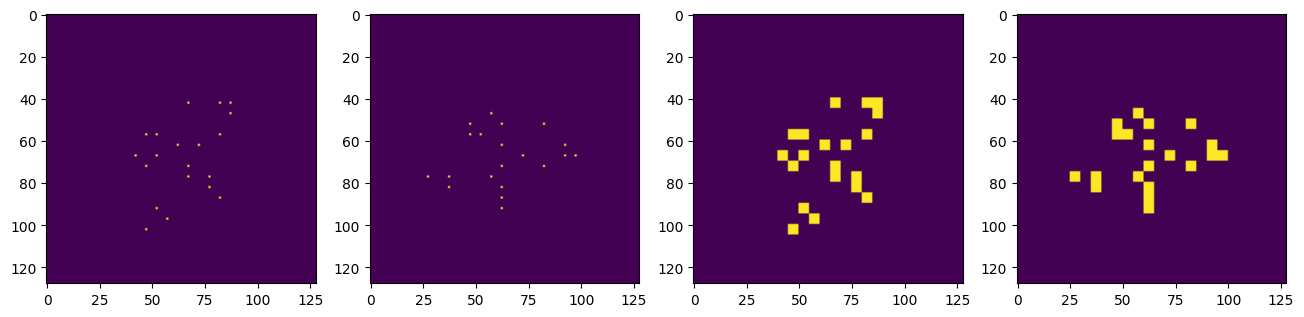

In [77]:
signal_ind = RNG.choice(sgr.signals_input.shape[0])
# signal_ind = 0
signal_input = xp_array_from_gpu(sgr.signals_input[signal_ind])
signal_output = xp_array_from_gpu(sgr.signals_output[signal_ind])

# xy_list_input = PIXEL_FEATURE_XY_ARRAY[debundle_sbv(signal_input, PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)]
# xy_list_output = PIXEL_FEATURE_XY_ARRAY[debundle_sbv(signal_output, PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)]
# ohe_input = xy_list_to_ohe_vec(xy_list_input)
# ohe_output = xy_list_to_ohe_vec(xy_list_output)

pixel_feature_inds = debundle_sbv(signal_input, PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)
bitmap_mask_input = PIXEL_FEATURE_BITMAP_MASKS[pixel_feature_inds].sum(axis=0)
pixel_feature_inds = debundle_sbv(signal_output, PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)
bitmap_mask_output = PIXEL_FEATURE_BITMAP_MASKS[pixel_feature_inds].sum(axis=0)
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_figwidth(16)
ax1.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_input[signal_ind])))
ax2.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_output[signal_ind])))
ax3.imshow(vec_to_square_matrix(bitmap_mask_input))
ax4.imshow(vec_to_square_matrix(bitmap_mask_output));

# Test

In [80]:
df_clusters = pd.read_sql('SELECT output_bit, metas, nzb_list FROM clusters WHERE encoding=:encoding AND transf_code=:transf_code', 
                          params={
                              'encoding': HP_SIGNAL_ENCODING, 
                              'transf_code': TRANSF_CODE},
                          con=transfs_db_con)
clusters = []
cluster_metas = []

for cluster_row in tqdm(df_clusters.itertuples(), total=len(df_clusters)):
    cluster_nzb_list_for_output_bit = pickle.loads(cluster_row.nzb_list)
    cluster_metas_for_output_bit = pickle.loads(cluster_row.metas)
    assert len(cluster_nzb_list_for_output_bit) == len(cluster_metas_for_output_bit)

    for nzb, meta in zip(cluster_nzb_list_for_output_bit, cluster_metas_for_output_bit):
        assert len(nzb) > 0
        
        # if meta.state in [ClusterState.PROD_WORK, ClusterState.PROD_ETERNAL]:
        if meta.state in [ClusterState.PROD_ETERNAL]:
            cluster = np.zeros(HP_SIGNAL_VEC_LEN, dtype='f')
            cluster[nzb] = 1
            clusters.append(cluster)
        
            cluster_ind = len(clusters)
            meta.cluster_ind = cluster_ind
            cluster_metas.append(meta)

clusters = np.vstack(clusters)
assert clusters.shape[0] == len(cluster_metas)
    
cluster_ones_counts = np.array(list(map(lambda m: m.ones_count, cluster_metas)), dtype='f')
cluster_output_bits = np.array(list(map(lambda m: m.output_bit, cluster_metas)), dtype='i')
cluster_input_bits_list = list(map(lambda m: m.input_bits, cluster_metas))
clusters.shape

  0%|          | 0/941 [00:00<?, ?it/s]

(42018, 1000)

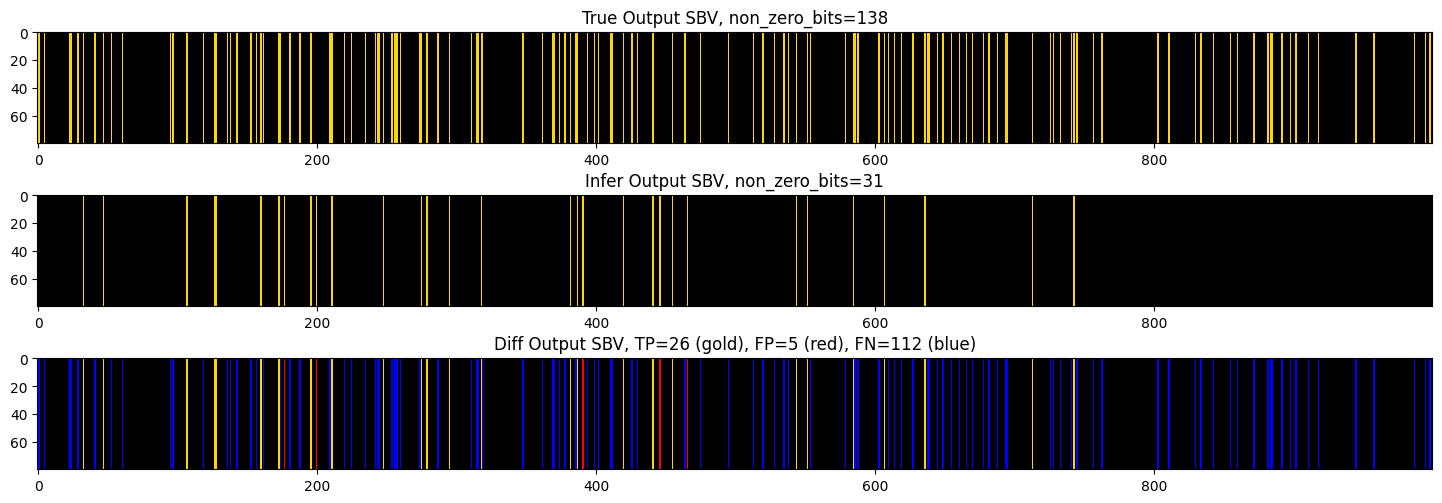

In [81]:
signals_generator = RealImageSignalsGenerator(TRANSF, 1, 1)
# signals_generator = PooledPixelFeatureSignalsGenerator(TRANSF, 1, 100)
sgr = signals_generator()

input_sbv = sgr.signals_input[0]
true_output_sbv = sgr.signals_output[0]
infer_output_sbv = np.zeros_like(input_sbv)

activated_clusters_boolmap = (clusters @ input_sbv) >= cluster_ones_counts
output_bit_to_activated_clusters_count = Counter(cluster_output_bits[activated_clusters_boolmap])
infer_output_sbv[list(output_bit_to_activated_clusters_count.keys())] = list(output_bit_to_activated_clusters_count.values())
infer_output_sbv = np.where(infer_output_sbv > 0, 1, 0)
condition_00 = (true_output_sbv == 0) & (infer_output_sbv == 0)
condition_01 = (true_output_sbv == 0) & (infer_output_sbv == 1)
condition_11 = (true_output_sbv == 1) & (infer_output_sbv == 1)
diff_output_sbv = np.where(condition_00, 0, np.where(condition_11, 1, np.where(condition_01, 2, 3)))

colors = ['black', 'gold', 'red', 'blue']
bounds = [0, 1, 2, 3, 4]
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_figwidth(18)
fig.set_figheight(6)
ax1.set_title(f'True Output SBV, non_zero_bits={np.count_nonzero(true_output_sbv)}')
ax1.imshow(np.ones((80, 1)) * true_output_sbv, interpolation='none', cmap=cmap, norm=norm);
ax2.set_title(f'Infer Output SBV, non_zero_bits={np.count_nonzero(infer_output_sbv)}')
ax2.imshow(np.ones((80, 1)) * infer_output_sbv, interpolation='none', cmap=cmap, norm=norm);
ax3.set_title(f'Diff Output SBV, TP={(diff_output_sbv == 1).sum()} (gold), FP={(diff_output_sbv == 2).sum()} (red), FN={(diff_output_sbv == 3).sum()} (blue)')
ax3.imshow(np.ones((80, 1)) * diff_output_sbv, interpolation='none', cmap=cmap, norm=norm);